## AIM: Obtain patient-level predictions from best models

For the best models patient-level predictions will be obtained. These patient-level predictions will be determined by summing the propabilities of the epoch predictions and taking the highest probability class.

In [1]:
import numpy as np
import pandas as pd
import sklearn
import pickle
import joblib
import mne
import os
import matplotlib.pyplot as plt
import yaml

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV, GroupShuffleSplit
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer, fbeta_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import os

import optuna

import lightning.pytorch as pl
import torch
import torch_geometric
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, BatchNorm1d, Dropout, Dropout1d
from torch_geometric.nn import  GCNConv, global_add_pool,GATConv,GINConv, GATv2Conv
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch_geometric.utils.convert import from_networkx, to_networkx
import lightning.pytorch as pl
from torchmetrics import F1Score, ConfusionMatrix
from lightning.pytorch.tuner import Tuner
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, TQDMProgressBar, RichProgressBar
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

%matplotlib inline

## Loading in feature data

## Predictions

#### GBC with handcrafted features

In [15]:
# load nested cv results
nested_cv = joblib.load(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\saved_models\nested_cv_stat_gbc_ec.pkl')
# obtain best model during nested CV
best_score_index = np.argmax(nested_cv['test_score'])
best_model = nested_cv['estimator'][best_score_index]
print('Parameters of the best model:', best_model.best_params_)

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.4.0 when using version 1.4.2. This might

Parameters of the best model: {'gbc__subsample': 0.5, 'gbc__n_estimators': 500, 'gbc__min_samples_split': 5, 'gbc__loss': 'log_loss', 'gbc__learning_rate': 0.008380358985673617, 'gbc__criterion': 'friedman_mse'}


In [16]:
# obtain the epoch-level predictions

cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls

# assign groups (IDs) for GroupKFold
groups = df_stat_features_ec['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric columns
numeric_cols = [num_col for num_col in df_stat_features_ec.columns if 'EC' in num_col]
 
X = df_stat_features_ec[numeric_cols]
Y = df_stat_features_ec['diagnosis']
# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ],
    remainder='drop',
    n_jobs=-1)

# get the hyperparameters from the best model of the nested CV
best_params = {}
for hyperparameter in best_model.best_params_:
    key = hyperparameter[5:]
    best_params[key] = best_model.best_params_[hyperparameter]
print(best_params)

steps = [('col_trans', col_trans), ('gbc', GradientBoostingClassifier(**best_params))]
pipeline = Pipeline(steps)
# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
Y_pred = le.inverse_transform(Y_pred)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': df_stat_features_ec['ID'], 'diagnosis': df_stat_features_ec['diagnosis'], 'prediction': Y_pred, 'proba': Y_score.tolist()})


# of instances: 2700
(2700, 5)
{'subsample': 0.5, 'n_estimators': 500, 'min_samples_split': 5, 'loss': 'log_loss', 'learning_rate': 0.008380358985673617, 'criterion': 'friedman_mse'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.1min finished


In [17]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = le.inverse_transform(sum_probas['proba_prediction'])

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_stat_features_ec.groupby('ID')['diagnosis'].first().values
df_patient_predictions.sample(5)

,ID,prediction,proba_prediction,diagnosis
40,sub-87971021,HEALTHY,HEALTHY,SMC
13,sub-87967781,ADHD,HEALTHY,SMC
108,sub-88036037,OCD,OCD,MDD
138,sub-88049585,SMC,SMC,HEALTHY
142,sub-88052057,OCD,OCD,ADHD


In [18]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = np.unique(Y)

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.48      0.44      0.46        45
     HEALTHY       0.41      0.44      0.43        45
         MDD       0.40      0.31      0.35        45
         OCD       0.34      0.36      0.35        45
         SMC       0.44      0.51      0.47        45

    accuracy                           0.41       225
   macro avg       0.41      0.41      0.41       225
weighted avg       0.41      0.41      0.41       225

f1_score: 0.41147098418327577

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.51      0.47      0.49        45
     HEALTHY       0.49      0.51      0.50        45
         MDD       0.36      0.27      0.31        45
         OCD       0.33      0.33      0.33        45
         SMC       0.47      0.60      0.52        45

    accuracy                           0.44       225
   macro avg     

Text(0.5, 1.0, 'Max probability prediction normalized')

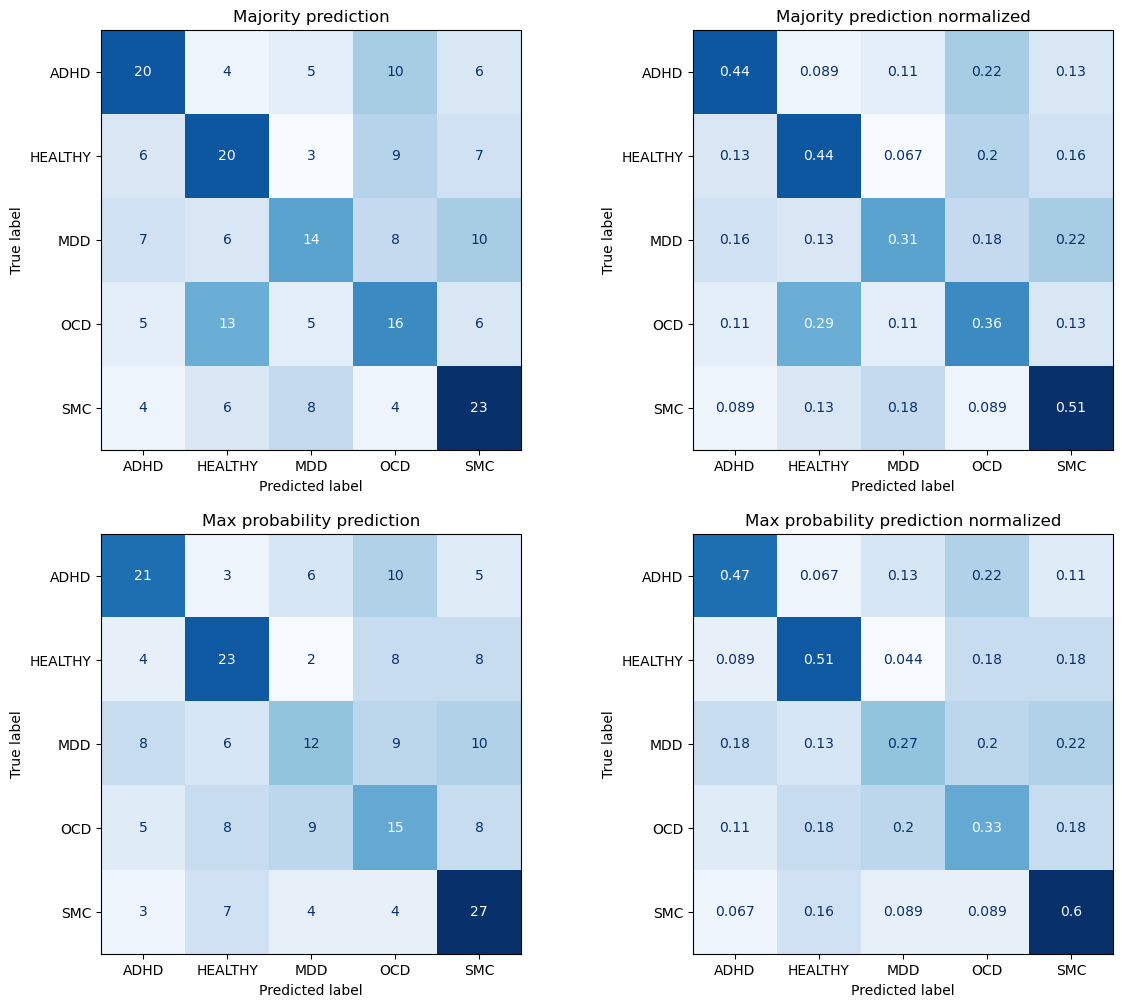

In [19]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

## GNNs

#### GCNConv with log_softmax activation function and NLLLoss

In [12]:
#Model
import lightning.pytorch as pl
from torchmetrics import F1Score, ConfusionMatrix
from torch.nn import Dropout1d
import seaborn as sns
import matplotlib.pyplot as plt

n_features = 25 # [Delta, Theta, Alpha, Beta, Gamma] * [mean, median, std, skew, kurt]
param = 64
num_classes = 5 # healthy, ADHD, MDD, OCD, SMC

class GCN(pl.LightningModule):
    def __init__(self, learning_rate, optimizer_name, dropout):
        super(GCN, self).__init__()
        self.learning_rate = learning_rate
        self.optimizer_name = optimizer_name

        self.conv1 = GCNConv(n_features, param, cached=False) # if you defined cache=True, the shape of batch must be same!
        self.bn1 = BatchNorm1d(param)
        self.do1 = Dropout1d(p=dropout)
        self.conv2 = GCNConv(param, param, cached=False)
        self.bn2 = BatchNorm1d(param)
        self.do2 = Dropout1d(p=dropout)
        self.fc1 = Linear(param, param)
        self.bn3 = BatchNorm1d(param)
        self.do3 = Dropout1d(p=dropout)
        self.fc2 = Linear(param, 8)
        self.fc3 = Linear(8, num_classes)

        # add metrics
        self.train_f1 = F1Score(task='multiclass', num_classes=num_classes, average='macro')
        self.val_f1 = F1Score(task='multiclass', num_classes=num_classes, average='macro')
        self.val_cm = ConfusionMatrix(task = 'binary', num_classes=num_classes, threshold=0.05)
        self.validation_step_yhats = []
        self.validation_step_ys = []

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = self.do1(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn2(x)
        x = self.do2(x)
        x = global_add_pool(x, data.batch)
        x = F.relu(self.fc1(x))
        x = self.bn3(x)
        x = self.do3(x)
        x = F.relu(self.fc2(x))
        #x = F.dropout(x, p=0.2, training=self.training)
        x = torch.flatten(x, start_dim=1)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1) # Activation function for classification
        return x
    
    def configure_optimizers(self):
        if self.optimizer_name == 'Adam':
            optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        elif self.optimizer_name == 'RMSprop':
            optimizer = torch.optim.RMSprop(self.parameters(), lr=self.learning_rate)
        elif self.optimizer_name == 'SGD':
            optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        else:
            raise ValueError(f'Unsupported optimizer: {self.optimizer_name}')
        return optimizer
    
    def training_step(self, train_batch, batch_idx):
            x, y = train_batch.x, train_batch.y
            output = self.forward(train_batch)
            loss = F.nll_loss(output, y)
            y_hat = output.argmax(dim=1)
            self.log('train_loss', loss, on_epoch=True, prog_bar=True)
            self.log('train_f1', self.train_f1(y, y_hat), on_epoch=True, prog_bar=True)
            return loss
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch.x, val_batch.y
        output = self.forward(val_batch)
        loss = F.nll_loss(output, y)
        y_hat = output.argmax(dim=1)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_f1', self.val_f1(y, y_hat), on_epoch=True, prog_bar=True)
        self.validation_step_yhats.append(y_hat)
        self.validation_step_ys.append(y)
        return loss
    
    def test_step(self, test_batch, batch_idx):
        x, y = test_batch.x, test_batch.y
        output = self.forward(test_batch)
        loss = F.nll_loss(output, y)
        y_hat = output.argmax(dim=1)
        self.log('test_loss', loss, on_epoch=True, prog_bar=True)
        self.log('test_f1', self.val_f1(y, y_hat), on_epoch=True, prog_bar=True)
        return loss

    # def on_train_epoch_end(self, training_step_outputs):
    #     # compute metrics
    #     train_f1 = self.train_f1.compute()
    #     # log metrics
    #     self.log("epoch_train_f1", train_f1)
    #     # reset all metrics
    #     self.train_f1.reset()
    #     print(f"\nf1: {train_f1:.4}")

    # def on_validation_epoch_end(self):
    #     # plot confusion matrix
    #     y_hat = torch.cat(self.validation_step_yhats)
    #     y = torch.cat(self.validation_step_ys)
    #     confusion_matrix = self.val_cm(y_hat, y.int())

    #     confusion_matrix_computed = confusion_matrix.detach().cpu().numpy().astype(int)

    #     df_cm = pd.DataFrame(confusion_matrix_computed)
    #     plt.figure(figsize = (10,7))
    #     fig_ = sns.heatmap(df_cm, annot=True, cmap='Spectral').get_figure()
    #     plt.close(fig_)
    #     self.loggers[0].experiment.add_figure("Confusion matrix", fig_, self.current_epoch)

    #     self.validation_step_yhats.clear() # free memory
    #     self.validation_step_ys.clear()
    
    def predict_step(self, batch):
        x, y = batch.x, batch.y
        y_proba = self.forward(batch)
        # y_hat = output.argmax(dim=1)
        return y_proba


    # def backward(self, trainer, loss, optimizer, optimizer_idx):
    #     loss.backward()
    
    # def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx):
    #     optimizer.step()
    #     optimizer.zero_grad()

#### Model: graphLambda without edge_attr

In [13]:
import lightning.pytorch as pl
from torchmetrics import F1Score, ConfusionMatrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch_geometric
from torch.nn import Sequential, Linear, ReLU, BatchNorm1d, Dropout, Dropout1d, ModuleList
import torch.nn.functional as F
from torch_geometric.nn import  GCNConv, global_add_pool, GATConv, GINConv


n_features = 25 # [Delta, Theta, Alpha, Beta, Gamma] * [mean, median, std, skew, kurt]
num_classes = 5 # healthy, ADHD, MDD, OCD, SMC

class graphLambda_wo_edge_attr(pl.LightningModule):
    def __init__(self, learning_rate, optimizer_name, fc_layers, dropout):
        super(graphLambda_wo_edge_attr, self).__init__()
        self.learning_rate = learning_rate
        self.optimizer_name = optimizer_name

        #GCN-representation
        self.conv1 = GCNConv(n_features, 256, cached=False )
        self.bn01 = BatchNorm1d(256)
        self.conv2 = GCNConv(256, 128, cached=False )
        self.bn02 = BatchNorm1d(128)
        self.conv3 = GCNConv(128, 128, cached=False)
        self.bn03 = BatchNorm1d(128)
        #GAT-representation
        self.gat1 = GATConv(n_features, 256, heads=3)
        self.bn11 = BatchNorm1d(256*3)
        self.gat2 = GATConv(256*3, 128, heads=3)
        self.bn12 = BatchNorm1d(128*3)
        self.gat3 = GATConv(128*3, 128, heads=3)
        self.bn13 = BatchNorm1d(128*3)
        #GIN-representation
        fc_gin1=Sequential(Linear(n_features, 256), ReLU(), Linear(256, 256))
        self.gin1 = GINConv(fc_gin1)
        self.bn21 = BatchNorm1d(256)
        fc_gin2=Sequential(Linear(256, 128), ReLU(), Linear(128, 128))
        self.gin2 = GINConv(fc_gin2)
        self.bn22 = BatchNorm1d(128)
        fc_gin3=Sequential(Linear(128, 64), ReLU(), Linear(64, 64))
        self.gin3 = GINConv(fc_gin3)
        self.bn23 = BatchNorm1d(64)
        # Fully connected layers for concatinating outputs (varied depending on fc_layers hyperparameter)
        self.fcs = ModuleList()
        self.dropouts = ModuleList()
        input_size = 128*4 + 64 # Input size for the first layer
        output_size = num_classes # Output size for the last layer
        sizes = np.linspace(input_size, output_size, fc_layers + 1, dtype=int) # Calculate the size for each layer
        for i in range(fc_layers): # Create the layers
            self.fcs.append(Linear(sizes[i], sizes[i + 1]))
            if i < fc_layers - 1:  # Append dropout only if it's not the last layer
                self.dropouts.append(Dropout(p=dropout))

        # add metrics
        self.train_f1 = F1Score(task='multiclass', num_classes=num_classes, average='macro')
        self.val_f1 = F1Score(task='multiclass', num_classes=num_classes, average='macro')
        self.val_cm = ConfusionMatrix(task = 'binary', num_classes=num_classes, threshold=0.05)
        self.validation_step_yhats = []
        self.validation_step_ys = []
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        y=x
        z=x
        #GCN-representation
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn01(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn02(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.bn03(x)
        x = global_add_pool(x, data.batch)
        #GAT-representation
        y = F.relu(self.gat1(y, edge_index))
        y = self.bn11(y)
        y = F.relu(self.gat2(y, edge_index))
        y = self.bn12(y)
        y = F.relu(self.gat3(y, edge_index))
        y = self.bn13(y)
        y = global_add_pool(y, data.batch)
        #GIN-representation
        z = F.relu(self.gin1(z, edge_index))
        z = self.bn21(z)
        z = F.relu(self.gin2(z, edge_index))
        z = self.bn22(z)
        z = F.relu(self.gin3(z, edge_index))
        z = self.bn23(z)
        z = global_add_pool(z, data.batch)
        #Concatinating_representations
        cr=torch.cat((x,y,z),1)
        for i, fc in enumerate(self.fcs):
            cr = F.relu(fc(cr))
            if i < len(self.fcs) - 1:  # Apply dropout only if it's not the last layer
                cr = self.dropouts[i](cr)
        #cr = F.relu(cr).view(-1)
        cr = F.log_softmax(cr, dim=1) # Activation function for classification
        return cr  
    
    def configure_optimizers(self):
        if self.optimizer_name == 'Adam':
            optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        elif self.optimizer_name == 'RMSprop':
            optimizer = torch.optim.RMSprop(self.parameters(), lr=self.learning_rate)
        elif self.optimizer_name == 'SGD':
            optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        else:
            raise ValueError(f'Unsupported optimizer: {self.optimizer_name}')
        return optimizer
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch.x, train_batch.y
        output = self.forward(train_batch)
        output = output.to(torch.float)
        y = y.to(torch.long)
        loss = F.nll_loss(output, y)
        y_hat = output.argmax(dim=1)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        self.log('train_f1', self.train_f1(y, y_hat), on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch.x, val_batch.y
        output = self.forward(val_batch)
        output = output.to(torch.float)
        y = y.to(torch.long)
        loss = F.nll_loss(output, y)
        y_hat = output.argmax(dim=1)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_f1', self.val_f1(y, y_hat), on_epoch=True, prog_bar=True)
        self.validation_step_yhats.append(y_hat)
        self.validation_step_ys.append(y)
        return loss
    
    def test_step(self, test_batch, batch_idx):
        x, y = test_batch.x, test_batch.y
        output = self.forward(test_batch)
        output = output.to(torch.float)
        y = y.to(torch.long)
        loss = F.nll_loss(output, y)
        y_hat = output.argmax(dim=1)
        self.log('test_loss', loss, on_epoch=True, prog_bar=True)
        self.log('test_f1', self.val_f1(y, y_hat), on_epoch=True, prog_bar=True)
        return loss
    
    # def on_train_epoch_end(self, training_step_outputs):
    #     # compute metrics
    #     train_f1 = self.train_f1.compute()
    #     # log metrics
    #     self.log("epoch_train_f1", train_f1)
    #     # reset all metrics
    #     self.train_f1.reset()
    #     print(f"\nf1: {train_f1:.4}")

    # def on_validation_epoch_end(self):
    #     # plot confusion matrix
    #     y_hat = torch.cat(self.validation_step_yhats)
    #     y = torch.cat(self.validation_step_ys)
    #     confusion_matrix = self.val_cm(y_hat, y.int())

    #     confusion_matrix_computed = confusion_matrix.detach().cpu().numpy().astype(int)

    #     df_cm = pd.DataFrame(confusion_matrix_computed)
    #     plt.figure(figsize = (10,7))
    #     fig_ = sns.heatmap(df_cm, annot=True, cmap='Spectral').get_figure()
    #     plt.close(fig_)
    #     self.loggers[0].experiment.add_figure("Confusion matrix", fig_, self.current_epoch)

    #     self.validation_step_yhats.clear() # free memory
    #     self.validation_step_ys.clear()
    
    def predict_step(self, batch):
        x, y = batch.x, batch.y
        y_proba = self.forward(batch)
        # loss = F.nll_loss(output, y)
        # y_hat = output.argmax(dim=1)
        return y_proba

#### Model: graphLambda with edge_attr

In [14]:
#Model
import lightning.pytorch as pl
from torchmetrics import F1Score, ConfusionMatrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch_geometric
from torch.nn import Sequential, Linear, ReLU, BatchNorm1d, Dropout, Dropout1d, ModuleList
import torch.nn.functional as F
from torch_geometric.nn import  GCNConv, global_add_pool, GATConv, GINConv, GATv2Conv


n_features = 25 # [Delta, Theta, Alpha, Beta, Gamma] * [mean, median, std, skew, kurt]
num_classes = 5 # healthy, ADHD, MDD, OCD, SMC
n_edge_attrs = 5 # [Delta, Theta, Alpha, Beta, Gamma]

class graphLambda_w_edge_attr(pl.LightningModule):
    def __init__(self, learning_rate, optimizer_name, fc_layers, dropout):
        super(graphLambda_w_edge_attr, self).__init__()
        self.learning_rate = learning_rate
        self.optimizer_name = optimizer_name

        #GCN-representation
        self.conv1 = GCNConv(n_features, 256, cached=False )
        self.bn01 = BatchNorm1d(256)
        self.conv2 = GCNConv(256, 128, cached=False )
        self.bn02 = BatchNorm1d(128)
        self.conv3 = GCNConv(128, 128, cached=False)
        self.bn03 = BatchNorm1d(128)
        #GAT-representation
        self.gat1 = GATv2Conv(n_features, 256, heads=3, edge_dim=n_edge_attrs)
        self.bn11 = BatchNorm1d(256*3)
        self.gat2 = GATv2Conv(256*3, 128, heads=3, edge_dim=n_edge_attrs)
        self.bn12 = BatchNorm1d(128*3)
        self.gat3 = GATv2Conv(128*3, 128, heads=3, edge_dim=n_edge_attrs)
        self.bn13 = BatchNorm1d(128*3)
        #GIN-representation
        fc_gin1=Sequential(Linear(n_features, 256), ReLU(), Linear(256, 256))
        self.gin1 = GINConv(fc_gin1)
        self.bn21 = BatchNorm1d(256)
        fc_gin2=Sequential(Linear(256, 128), ReLU(), Linear(128, 128))
        self.gin2 = GINConv(fc_gin2)
        self.bn22 = BatchNorm1d(128)
        fc_gin3=Sequential(Linear(128, 64), ReLU(), Linear(64, 64))
        self.gin3 = GINConv(fc_gin3)
        self.bn23 = BatchNorm1d(64)
        # Fully connected layers for concatinating outputs (varied depending on fc_layers hyperparameter)
        self.fcs = ModuleList()
        self.dropouts = ModuleList()
        input_size = 128*4 + 64 # Input size for the first layer
        output_size = num_classes # Output size for the last layer
        sizes = np.linspace(input_size, output_size, fc_layers + 1, dtype=int) # Calculate the size for each layer
        for i in range(fc_layers): # Create the layers
            self.fcs.append(Linear(sizes[i], sizes[i + 1]))
            if i < fc_layers - 1:  # Append dropout only if it's not the last layer
                self.dropouts.append(Dropout(p=dropout))

        # add metrics
        self.train_f1 = F1Score(task='multiclass', num_classes=num_classes, average='macro')
        self.val_f1 = F1Score(task='multiclass', num_classes=num_classes, average='macro')
        self.val_cm = ConfusionMatrix(task = 'binary', num_classes=num_classes, threshold=0.05)
        self.validation_step_yhats = []
        self.validation_step_ys = []
        
    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        y=x
        z=x
        #GCN-representation
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn01(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn02(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.bn03(x)
        x = global_add_pool(x, data.batch)
        #GAT-representation
        y = F.relu(self.gat1(y, edge_index, edge_attr))
        y = self.bn11(y)
        y = F.relu(self.gat2(y, edge_index, edge_attr))
        y = self.bn12(y)
        y = F.relu(self.gat3(y, edge_index, edge_attr))
        y = self.bn13(y)
        y = global_add_pool(y, data.batch)
        #GIN-representation
        z = F.relu(self.gin1(z, edge_index))
        z = self.bn21(z)
        z = F.relu(self.gin2(z, edge_index))
        z = self.bn22(z)
        z = F.relu(self.gin3(z, edge_index))
        z = self.bn23(z)
        z = global_add_pool(z, data.batch)
        #Concatinating_representations
        cr=torch.cat((x,y,z),1)
        for i, fc in enumerate(self.fcs):
            cr = F.relu(fc(cr))
            if i < len(self.fcs) - 1:  # Apply dropout only if it's not the last layer
                cr = self.dropouts[i](cr)
        #cr = F.relu(cr).view(-1)
        cr = F.log_softmax(cr, dim=1) # Activation function for classification
        return cr  
    
    def configure_optimizers(self):
        if self.optimizer_name == 'Adam':
            optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        elif self.optimizer_name == 'RMSprop':
            optimizer = torch.optim.RMSprop(self.parameters(), lr=self.learning_rate)
        elif self.optimizer_name == 'SGD':
            optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        else:
            raise ValueError(f'Unsupported optimizer: {self.optimizer_name}')
        return optimizer
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch.x, train_batch.y
        output = self.forward(train_batch)
        output = output.to(torch.float)
        y = y.to(torch.long)
        loss = F.nll_loss(output, y)
        y_hat = output.argmax(dim=1)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        self.log('train_f1', self.train_f1(y, y_hat), on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch.x, val_batch.y
        output = self.forward(val_batch)
        output = output.to(torch.float)
        y = y.to(torch.long)
        loss = F.nll_loss(output, y)
        y_hat = output.argmax(dim=1)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_f1', self.val_f1(y, y_hat), on_epoch=True, prog_bar=True)
        self.validation_step_yhats.append(y_hat)
        self.validation_step_ys.append(y)
        return loss
    
    def test_step(self, test_batch, batch_idx):
        x, y = test_batch.x, test_batch.y
        output = self.forward(test_batch)
        output = output.to(torch.float)
        y = y.to(torch.long)
        loss = F.nll_loss(output, y)
        y_hat = output.argmax(dim=1)
        self.log('test_loss', loss, on_epoch=True, prog_bar=True)
        self.log('test_f1', self.val_f1(y, y_hat), on_epoch=True, prog_bar=True)
        return loss
    
    # def on_train_epoch_end(self, training_step_outputs):
    #     # compute metrics
    #     train_f1 = self.train_f1.compute()
    #     # log metrics
    #     self.log("epoch_train_f1", train_f1)
    #     # reset all metrics
    #     self.train_f1.reset()
    #     print(f"\nf1: {train_f1:.4}")

    # def on_validation_epoch_end(self):
    #     # plot confusion matrix
    #     y_hat = torch.cat(self.validation_step_yhats)
    #     y = torch.cat(self.validation_step_ys)
    #     confusion_matrix = self.val_cm(y_hat, y.int())

    #     confusion_matrix_computed = confusion_matrix.detach().cpu().numpy().astype(int)

    #     df_cm = pd.DataFrame(confusion_matrix_computed)
    #     plt.figure(figsize = (10,7))
    #     fig_ = sns.heatmap(df_cm, annot=True, cmap='Spectral').get_figure()
    #     plt.close(fig_)
    #     self.loggers[0].experiment.add_figure("Confusion matrix", fig_, self.current_epoch)

    #     self.validation_step_yhats.clear() # free memory
    #     self.validation_step_ys.clear()
    
    def predict_step(self, batch):
        x, y = batch.x, batch.y
        y_proba = self.forward(batch)
        # loss = F.nll_loss(output, y)
        # y_hat = output.argmax(dim=1)
        return y_proba

### EC

In [17]:
# split the data into train, validation and test sets, using the same split as one of the baseline models using nested cross-validation
baseline_train_ids = data_split_groups['EC'][0]
baseline_val_ids = data_split_groups['EC'][1]
baseline_test_ids = data_split_groups['EC'][2]

# first splitting validation data using the first split from the baseline RF model
groups = [elem for elem in subjects_ec_ids for i in range(12)] # times 12 for each epoch
groups_array = np.array(groups)
baseline_train_idxs = []
for train_id in baseline_train_ids:
    indices = np.where(groups_array == train_id)[0]  # Get the indices as an array
    baseline_train_idxs.extend(indices)  # Extend the list with the array of indices

baseline_val_idxs = []
for val_id in baseline_val_ids:
    indices = np.where(groups_array == val_id)[0]  # Get the indices as an array
    baseline_val_idxs.extend(indices)  # Extend the list with the array of indices

baseline_test_idxs = []
for test_id in baseline_test_ids:
    indices = np.where(groups_array == test_id)[0]  # Get the indices as an array
    baseline_test_idxs.extend(indices)  # Extend the list with the array of indices

print(len(baseline_train_idxs), len(baseline_val_idxs), len(baseline_test_idxs))

print(f'{len(ec_graph_dataset) = }')
print(f'{len(baseline_train_idxs) = }, {len(baseline_val_idxs) = }, {len(baseline_test_idxs) = } total: {len(baseline_train_idxs)+len(baseline_val_idxs)+len(baseline_test_idxs)}')

X_train = [ec_graph_dataset[i] for i in baseline_train_idxs] 
X_val = [ec_graph_dataset[i] for i in baseline_val_idxs]
X_test = [ec_graph_dataset[i] for i in baseline_test_idxs]
Y_train =[ec_y_list[i] for i in baseline_train_idxs]
Y_val = [ec_y_list[i] for i in baseline_val_idxs]
Y_test = [ec_y_list[i] for i in baseline_test_idxs]
groups_train = [groups[i] for i in baseline_train_idxs]
groups_val = [groups[i] for i in baseline_val_idxs]
groups_test = [groups[i] for i in baseline_test_idxs]

1428 720 540
len(ec_graph_dataset) = 2688
len(baseline_train_idxs) = 1428, len(baseline_val_idxs) = 720, len(baseline_test_idxs) = 540 total: 2688


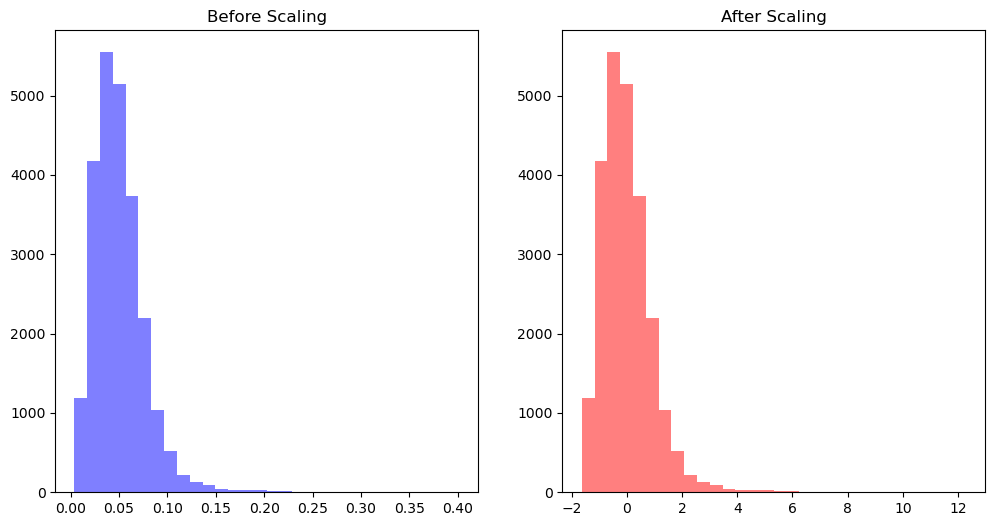

In [18]:
# standardize statistical node features
from sklearn.preprocessing import StandardScaler

# Concatenate all x values before scaling for the first feature, as a sanity check for standardization
x_before = np.concatenate([data.x.numpy()[:, 0] for data in X_train + X_val + X_test])

scaler = StandardScaler()
scaler.fit(np.vstack([data.x.numpy() for data in X_train + X_val]))


# Transform the x values of the data in X_train
for data in X_train:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Transform the x values of the data in X_val
for data in X_val:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Transform the x values of the data in X_test
for data in X_test:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Concatenate all x values after scaling for the first feature, as a sanity check for standardization
x_after = np.concatenate([data.x.numpy()[:, 0] for data in X_train + X_val + X_test])

# Plot the distribution of the first x feature before and after scaling as a sanity check
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(x_before, bins=30, color='b', alpha=0.5)
plt.title('Before Scaling')

plt.subplot(1, 2, 2)
plt.hist(x_after, bins=30, color='r', alpha=0.5)
plt.title('After Scaling')

plt.show()

In [19]:
def filter_adjacency(edge_index, edge_attr, threshold):
    # Filter/select edges where the edge attributes are greater than the threshold in any of the five freq bands
    mask = (edge_attr > threshold).any(dim=1)
    filtered_edge_index = edge_index[:, mask]
    return filtered_edge_index

#### standard GCN

In [20]:
best_model_path = r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\tuning_results\best_models_during_tuning_lightning_logs\ec_stand_GCN_best_model_logs\checkpoints\epoch=3385-train_loss=0.78-train_f1=0.72-val_loss=1.87-val_f1=0.34.ckpt'
best_model_dir = '\\'.join(best_model_path.split('\\')[:-2]) + '\\'
print(best_model_dir)
hparams_path = best_model_dir + 'hparams.yaml'
# Load the hyperparameters from the YAML file
with open(hparams_path, 'r') as file:
    hyperparameters = yaml.safe_load(file)
print(hyperparameters)
learning_rate = hyperparameters['learning_rate']
optimizer_name = hyperparameters['optimizer_name']
dropout = hyperparameters['dropout']
edge_threshold = hyperparameters['edge_threshold']
best_model = GCN.load_from_checkpoint(best_model_path, learning_rate=learning_rate, optimizer_name=optimizer_name, dropout=dropout)

print(best_model.hparams)

# final eval on test data for the best model during tuning
X_test_best_trial = [data.clone() for data in X_test]
for data in X_test_best_trial:
    data.edge_index = filter_adjacency(data.edge_index, data.edge_attr, edge_threshold)
test_loader = DataLoader(X_test_best_trial, batch_size=len(X_test), shuffle=False,
                            drop_last=True)

trainer = Trainer(accelerator='gpu', devices=1, enable_progress_bar=False, enable_model_summary=False, logger=False, enable_checkpointing=False)

# obtain predictions
y_proba = trainer.predict(best_model, test_loader)
y_pred = y_proba[0].argmax(dim=1)

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': groups_test, 'diagnosis': Y_test, 'prediction': y_pred.numpy(), 'proba': y_proba[0].numpy().tolist()})
df_predictions.head(3)

D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\tuning_results\best_models_during_tuning_lightning_logs\ec_stand_GCN_best_model_logs\
{'batch_size': 850, 'dropout': 0.19957362442904492, 'edge_threshold': 0.6870663022472054, 'learning_rate': 0.0061543071358829676, 'optimizer_name': 'SGD'}


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\utilities\migration\utils.py:56: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.2.1


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


,ID,diagnosis,prediction,proba
0,sub-87965301,4,4,"[-4.509507179260254, -2.97389554977417, -1.253..."
1,sub-87965301,4,2,"[-1.7900493144989014, -1.5398309230804443, -1...."
2,sub-87965301,4,1,"[-1.4388355016708374, -1.328490138053894, -2.1..."


In [21]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = sum_probas['proba_prediction']

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_predictions.groupby('ID')['diagnosis'].first().values
df_patient_predictions.head(5)

,ID,prediction,proba_prediction,diagnosis
0,sub-87965301,1,1,4
1,sub-87967057,4,3,4
2,sub-87967729,4,4,4
3,sub-87968045,4,4,4
4,sub-87968677,3,3,4


In [22]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = le2.inverse_transform(np.unique(Y))

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.50      0.56      0.53         9
     HEALTHY       0.33      0.44      0.38         9
         MDD       0.43      0.33      0.38         9
         OCD       0.29      0.22      0.25         9
         SMC       0.56      0.56      0.56         9

    accuracy                           0.42        45
   macro avg       0.42      0.42      0.42        45
weighted avg       0.42      0.42      0.42        45

f1_score: 0.4175647451963242

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.50      0.56      0.53         9
     HEALTHY       0.40      0.44      0.42         9
         MDD       0.20      0.11      0.14         9
         OCD       0.22      0.22      0.22         9
         SMC       0.36      0.44      0.40         9

    accuracy                           0.36        45
   macro avg      

Text(0.5, 1.0, 'Max probability prediction normalized')

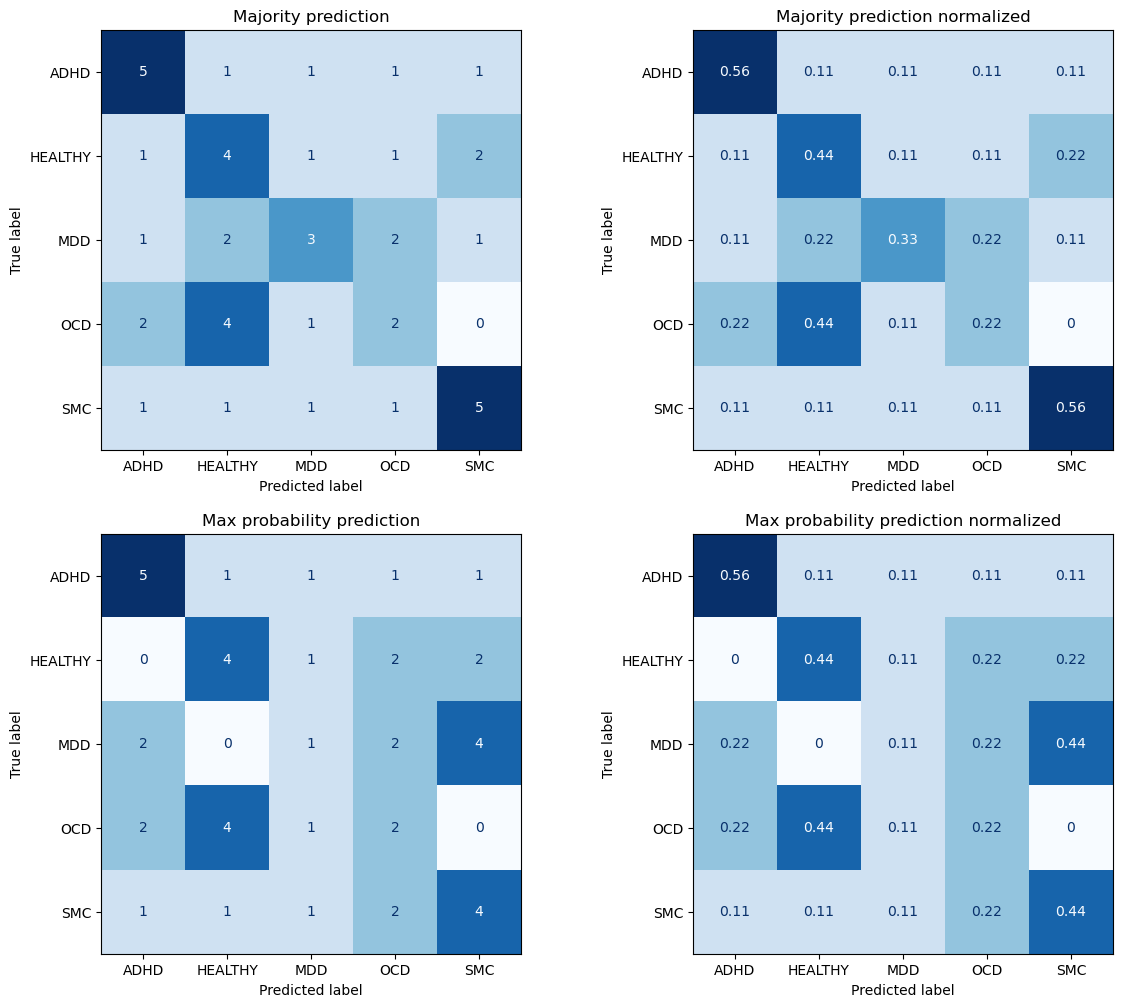

In [23]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

#### GraphLambda without edge attributes

In [24]:
best_model_path = r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\tuning_results\best_models_during_tuning_lightning_logs\ec_GL_wo_edge_best_model_logs\checkpoints\epoch=352-train_loss=0.38-train_f1=0.89-val_loss=3.67-val_f1=0.35.ckpt'
best_model_dir = '\\'.join(best_model_path.split('\\')[:-2]) + '\\'
print(best_model_dir)
hparams_path = best_model_dir + 'hparams.yaml'
# Load the hyperparameters from the YAML file
with open(hparams_path, 'r') as file:
    hyperparameters = yaml.safe_load(file)
print(hyperparameters)
learning_rate = hyperparameters['learning_rate']
optimizer_name = hyperparameters['optimizer_name']
dropout = hyperparameters['dropout']
edge_threshold = hyperparameters['edge_threshold']
fc_layers = hyperparameters['fc_layers']
best_model = graphLambda_wo_edge_attr.load_from_checkpoint(best_model_path, learning_rate=learning_rate, optimizer_name=optimizer_name, dropout=dropout, fc_layers=fc_layers)

print(best_model.hparams)

# final eval on test data for the best model during tuning
X_test_best_trial = [data.clone() for data in X_test]
for data in X_test_best_trial:
    data.edge_index = filter_adjacency(data.edge_index, data.edge_attr, edge_threshold)
test_loader = DataLoader(X_test_best_trial, batch_size=len(X_test), shuffle=False,
                            drop_last=True)

trainer = Trainer(accelerator='gpu', devices=1, enable_progress_bar=False, enable_model_summary=False, logger=False, enable_checkpointing=False)

# obtain predictions
y_proba = trainer.predict(best_model, test_loader)
y_pred = y_proba[0].argmax(dim=1)

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': groups_test, 'diagnosis': Y_test, 'prediction': y_pred.numpy(), 'proba': y_proba[0].numpy().tolist()})
df_predictions.head(3)

D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\tuning_results\best_models_during_tuning_lightning_logs\ec_GL_wo_edge_best_model_logs\
{'batch_size': 510, 'dropout': 0.07556209443203989, 'edge_threshold': 0.8266629052093692, 'fc_layers': 5, 'learning_rate': 0.02669066643467487, 'optimizer_name': 'SGD'}


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\utilities\migration\utils.py:56: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.2.1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


,ID,diagnosis,prediction,proba
0,sub-87965301,4,4,"[-8.740326881408691, -5.99491024017334, -4.673..."
1,sub-87965301,4,2,"[-3.9575154781341553, -4.279597282409668, -0.3..."
2,sub-87965301,4,0,"[-0.3536582589149475, -2.9699363708496094, -2...."


In [25]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = sum_probas['proba_prediction']

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_predictions.groupby('ID')['diagnosis'].first().values
df_patient_predictions.head(5)

,ID,prediction,proba_prediction,diagnosis
0,sub-87965301,0,4,4
1,sub-87967057,1,1,4
2,sub-87967729,1,4,4
3,sub-87968045,4,4,4
4,sub-87968677,1,3,4


In [26]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = le2.inverse_transform(np.unique(Y))

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.33      0.44      0.38         9
     HEALTHY       0.36      0.44      0.40         9
         MDD       0.33      0.33      0.33         9
         OCD       0.67      0.22      0.33         9
         SMC       0.30      0.33      0.32         9

    accuracy                           0.36        45
   macro avg       0.40      0.36      0.35        45
weighted avg       0.40      0.36      0.35        45

f1_score: 0.3526817042606516

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.40      0.44      0.42         9
     HEALTHY       0.44      0.44      0.44         9
         MDD       0.30      0.33      0.32         9
         OCD       0.50      0.22      0.31         9
         SMC       0.42      0.56      0.48         9

    accuracy                           0.40        45
   macro avg      

Text(0.5, 1.0, 'Max probability prediction normalized')

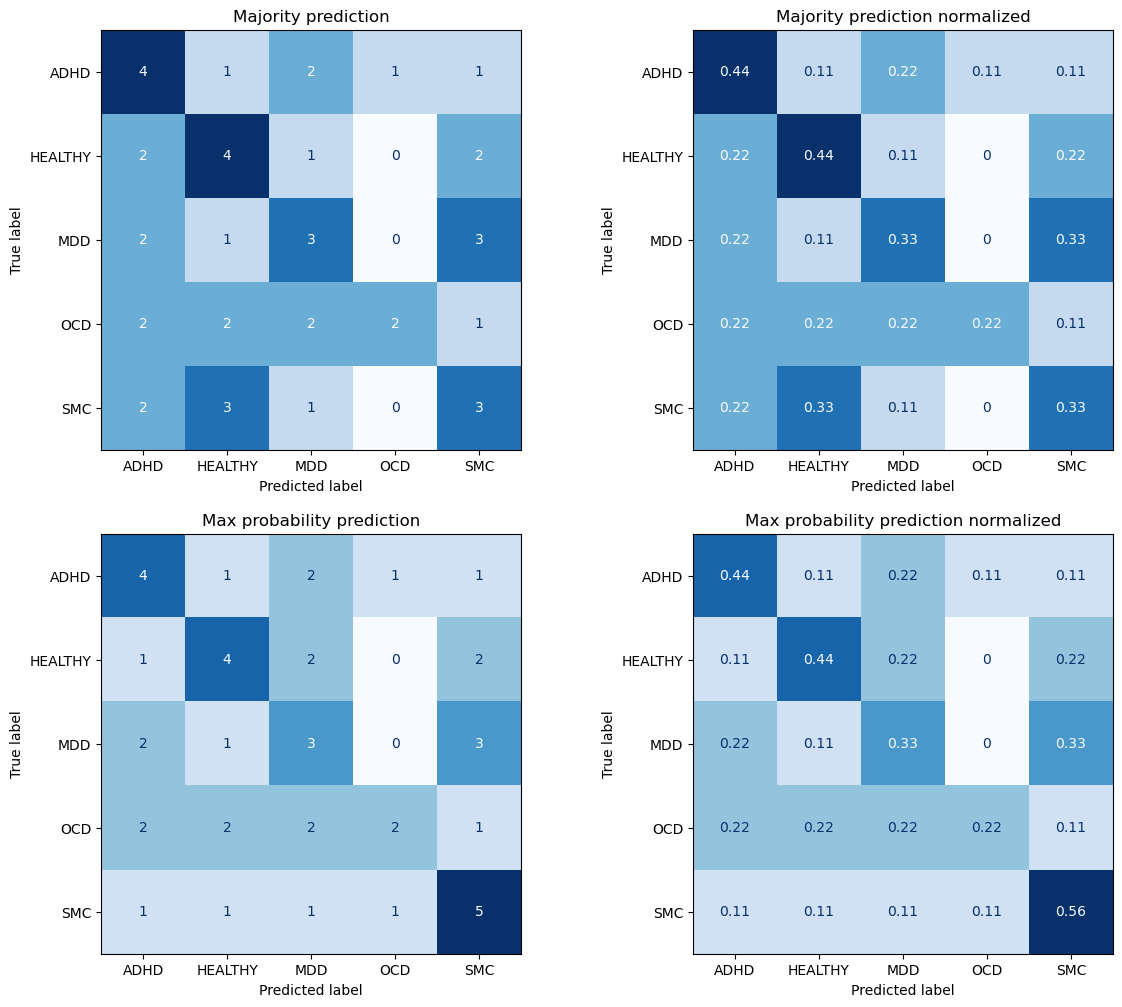

In [27]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

#### GraphLambda with edge attributes

In [28]:
best_model_path = r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\tuning_results\best_models_during_tuning_lightning_logs\ec_GL_with_edge_best_model_logs\checkpoints\epoch=1087-train_loss=0.33-train_f1=0.92-val_loss=2.10-val_f1=0.32.ckpt'
best_model_dir = '\\'.join(best_model_path.split('\\')[:-2]) + '\\'
print(best_model_dir)
hparams_path = best_model_dir + 'hparams.yaml'
# Load the hyperparameters from the YAML file
with open(hparams_path, 'r') as file:
    hyperparameters = yaml.safe_load(file)
print(hyperparameters)
learning_rate = hyperparameters['learning_rate']
optimizer_name = hyperparameters['optimizer_name']
dropout = hyperparameters['dropout']
fc_layers = hyperparameters['fc_layers']
best_model = graphLambda_w_edge_attr.load_from_checkpoint(best_model_path, learning_rate=learning_rate, optimizer_name=optimizer_name, dropout=dropout, fc_layers=fc_layers)

print(best_model.hparams)

# final eval on test data for the best model during tuning
test_loader = DataLoader(X_test, batch_size=len(X_test), shuffle=False,
                            drop_last=True)

trainer = Trainer(accelerator='gpu', devices=1, enable_progress_bar=False, enable_model_summary=False, logger=False, enable_checkpointing=False)

# obtain predictions
y_proba = trainer.predict(best_model, test_loader)
y_pred = y_proba[0].argmax(dim=1)

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': groups_test, 'diagnosis': Y_test, 'prediction': y_pred.numpy(), 'proba': y_proba[0].numpy().tolist()})
df_predictions.head(3)

D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\tuning_results\best_models_during_tuning_lightning_logs\ec_GL_with_edge_best_model_logs\
{'batch_size': 340, 'dropout': 0.118091618308195, 'fc_layers': 3, 'learning_rate': 0.0003330862976586279, 'optimizer_name': 'SGD'}


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\utilities\migration\utils.py:56: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.2.1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


,ID,diagnosis,prediction,proba
0,sub-87965301,4,4,"[-3.4379446506500244, -2.719395637512207, -2.0..."
1,sub-87965301,4,3,"[-3.2587103843688965, -3.133702278137207, -2.2..."
2,sub-87965301,4,0,"[-0.7139869332313538, -1.6602106094360352, -1...."


In [29]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = sum_probas['proba_prediction']

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_predictions.groupby('ID')['diagnosis'].first().values
df_patient_predictions.head(5)

,ID,prediction,proba_prediction,diagnosis
0,sub-87965301,1,1,4
1,sub-87967057,3,3,4
2,sub-87967729,1,1,4
3,sub-87968045,4,4,4
4,sub-87968677,3,3,4


In [30]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = le2.inverse_transform(np.unique(Y))

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.45      0.56      0.50         9
     HEALTHY       0.36      0.56      0.43         9
         MDD       0.43      0.33      0.38         9
         OCD       0.29      0.22      0.25         9
         SMC       0.33      0.22      0.27         9

    accuracy                           0.38        45
   macro avg       0.37      0.38      0.37        45
weighted avg       0.37      0.38      0.37        45

f1_score: 0.36528985507246375

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.40      0.44      0.42         9
     HEALTHY       0.42      0.56      0.48         9
         MDD       0.57      0.44      0.50         9
         OCD       0.25      0.22      0.24         9
         SMC       0.38      0.33      0.35         9

    accuracy                           0.40        45
   macro avg     

Text(0.5, 1.0, 'Max probability prediction normalized')

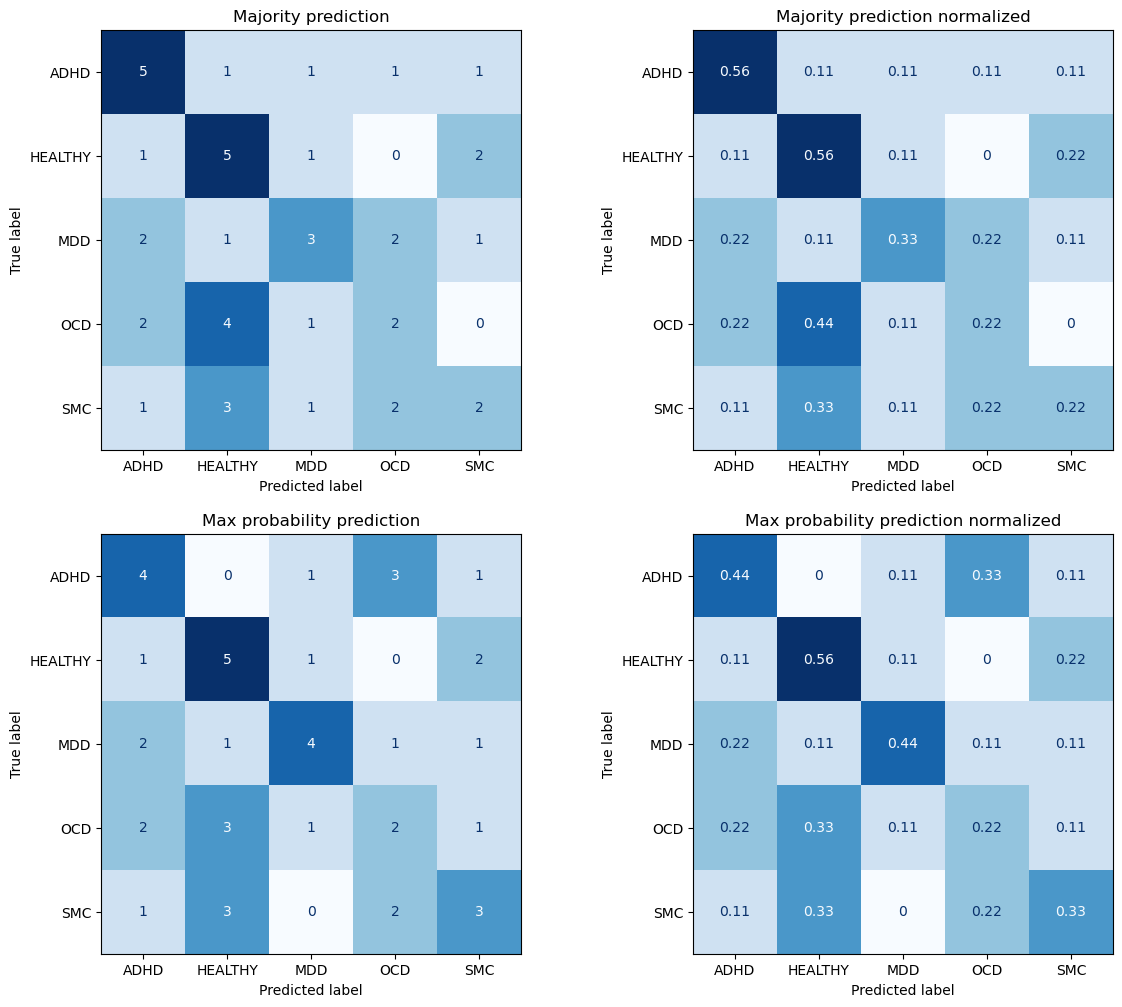

In [31]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

### EO

In [32]:
# split the data into train, validation and test sets, using the same split as one of the baseline models using nested cross-validation
baseline_train_ids = data_split_groups['EO'][0]
baseline_val_ids = data_split_groups['EO'][1]
baseline_test_ids = data_split_groups['EO'][2]

# first splitting validation data using the first split from the baseline RF model
groups = [elem for elem in subjects_eo_ids for i in range(12)] # times 12 for each epoch
groups_array = np.array(groups)
baseline_train_idxs = []
for train_id in baseline_train_ids:
    indices = np.where(groups_array == train_id)[0]  # Get the indices as an array
    baseline_train_idxs.extend(indices)  # Extend the list with the array of indices

baseline_val_idxs = []
for val_id in baseline_val_ids:
    indices = np.where(groups_array == val_id)[0]  # Get the indices as an array
    baseline_val_idxs.extend(indices)  # Extend the list with the array of indices

baseline_test_idxs = []
for test_id in baseline_test_ids:
    indices = np.where(groups_array == test_id)[0]  # Get the indices as an array
    baseline_test_idxs.extend(indices)  # Extend the list with the array of indices

print(len(baseline_train_idxs), len(baseline_val_idxs), len(baseline_test_idxs))

print(f'{len(eo_graph_dataset) = }')
print(f'{len(baseline_train_idxs) = }, {len(baseline_val_idxs) = }, {len(baseline_test_idxs) = } total: {len(baseline_train_idxs)+len(baseline_val_idxs)+len(baseline_test_idxs)}')

X_train = [eo_graph_dataset[i] for i in baseline_train_idxs] 
X_val = [eo_graph_dataset[i] for i in baseline_val_idxs]
X_test = [eo_graph_dataset[i] for i in baseline_test_idxs]
Y_train =[eo_y_list[i] for i in baseline_train_idxs]
Y_val = [eo_y_list[i] for i in baseline_val_idxs]
Y_test = [eo_y_list[i] for i in baseline_test_idxs]
groups_train = [groups[i] for i in baseline_train_idxs]
groups_val = [groups[i] for i in baseline_val_idxs]
groups_test = [groups[i] for i in baseline_test_idxs]

1440 720 540
len(eo_graph_dataset) = 2700
len(baseline_train_idxs) = 1440, len(baseline_val_idxs) = 720, len(baseline_test_idxs) = 540 total: 2700


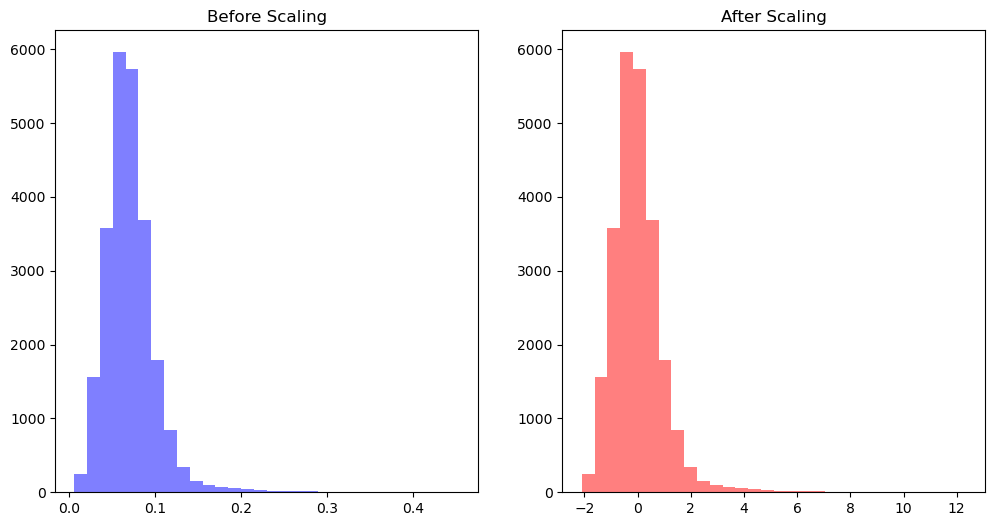

In [33]:
# standardize statistical node features
from sklearn.preprocessing import StandardScaler

# Concatenate all x values before scaling for the first feature, as a sanity check for standardization
x_before = np.concatenate([data.x.numpy()[:, 0] for data in X_train + X_val + X_test])

scaler = StandardScaler()
scaler.fit(np.vstack([data.x.numpy() for data in X_train + X_val]))


# Transform the x values of the data in X_train
for data in X_train:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Transform the x values of the data in X_val
for data in X_val:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Transform the x values of the data in X_test
for data in X_test:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Concatenate all x values after scaling for the first feature, as a sanity check for standardization
x_after = np.concatenate([data.x.numpy()[:, 0] for data in X_train + X_val + X_test])

# Plot the distribution of the first x feature before and after scaling as a sanity check
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(x_before, bins=30, color='b', alpha=0.5)
plt.title('Before Scaling')

plt.subplot(1, 2, 2)
plt.hist(x_after, bins=30, color='r', alpha=0.5)
plt.title('After Scaling')

plt.show()

#### standard GCN

In [34]:
best_model_path = r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\tuning_results\best_models_during_tuning_lightning_logs\eo_stand_GCN_best_model_logs\checkpoints\epoch=42-train_loss=1.45-train_f1=0.32-val_loss=1.55-val_f1=0.37.ckpt'
best_model_dir = '\\'.join(best_model_path.split('\\')[:-2]) + '\\'
print(best_model_dir)
hparams_path = best_model_dir + 'hparams.yaml'
# Load the hyperparameters from the YAML file
with open(hparams_path, 'r') as file:
    hyperparameters = yaml.safe_load(file)
print(hyperparameters)
learning_rate = hyperparameters['learning_rate']
optimizer_name = hyperparameters['optimizer_name']
dropout = hyperparameters['dropout']
edge_threshold = hyperparameters['edge_threshold']
best_model = GCN.load_from_checkpoint(best_model_path, learning_rate=learning_rate, optimizer_name=optimizer_name, dropout=dropout)

print(best_model.hparams)

# final eval on test data for the best model during tuning
X_test_best_trial = [data.clone() for data in X_test]
for data in X_test_best_trial:
    data.edge_index = filter_adjacency(data.edge_index, data.edge_attr, edge_threshold)
test_loader = DataLoader(X_test_best_trial, batch_size=len(X_test), shuffle=False,
                            drop_last=True)

trainer = Trainer(accelerator='gpu', devices=1, enable_progress_bar=False, enable_model_summary=False, logger=False, enable_checkpointing=False)

# obtain predictions
y_proba = trainer.predict(best_model, test_loader)
y_pred = y_proba[0].argmax(dim=1)

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': groups_test, 'diagnosis': Y_test, 'prediction': y_pred.numpy(), 'proba': y_proba[0].numpy().tolist()})
df_predictions.head(3)

D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\tuning_results\best_models_during_tuning_lightning_logs\eo_stand_GCN_best_model_logs\
{'batch_size': 170, 'dropout': 0.5117656632948554, 'edge_threshold': 0.8469389755689003, 'learning_rate': 0.05226985101691108, 'optimizer_name': 'Adam'}



c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\utilities\migration\utils.py:56: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.2.1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


,ID,diagnosis,prediction,proba
0,sub-87964717,4,4,"[-3.1189980506896973, -1.6198654174804688, -1...."
1,sub-87964717,4,4,"[-3.336059808731079, -1.9863624572753906, -1.7..."
2,sub-87964717,4,4,"[-3.9457125663757324, -1.3637590408325195, -2...."


In [35]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = sum_probas['proba_prediction']

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_predictions.groupby('ID')['diagnosis'].first().values
df_patient_predictions.head(5)

,ID,prediction,proba_prediction,diagnosis
0,sub-87964717,4,4,4
1,sub-87966789,1,1,4
2,sub-87967509,3,2,4
3,sub-87967957,0,1,4
4,sub-87968541,2,2,4


In [36]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = le2.inverse_transform(np.unique(Y))

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.31      0.44      0.36         9
     HEALTHY       0.33      0.33      0.33         9
         MDD       0.50      0.44      0.47         9
         OCD       0.38      0.33      0.35         9
         SMC       0.29      0.22      0.25         9

    accuracy                           0.36        45
   macro avg       0.36      0.36      0.35        45
weighted avg       0.36      0.36      0.35        45

f1_score: 0.35409982174688054

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.50      0.44      0.47         9
     HEALTHY       0.31      0.44      0.36         9
         MDD       0.40      0.44      0.42         9
         OCD       0.43      0.33      0.38         9
         SMC       0.29      0.22      0.25         9

    accuracy                           0.38        45
   macro avg     

Text(0.5, 1.0, 'Max probability prediction normalized')

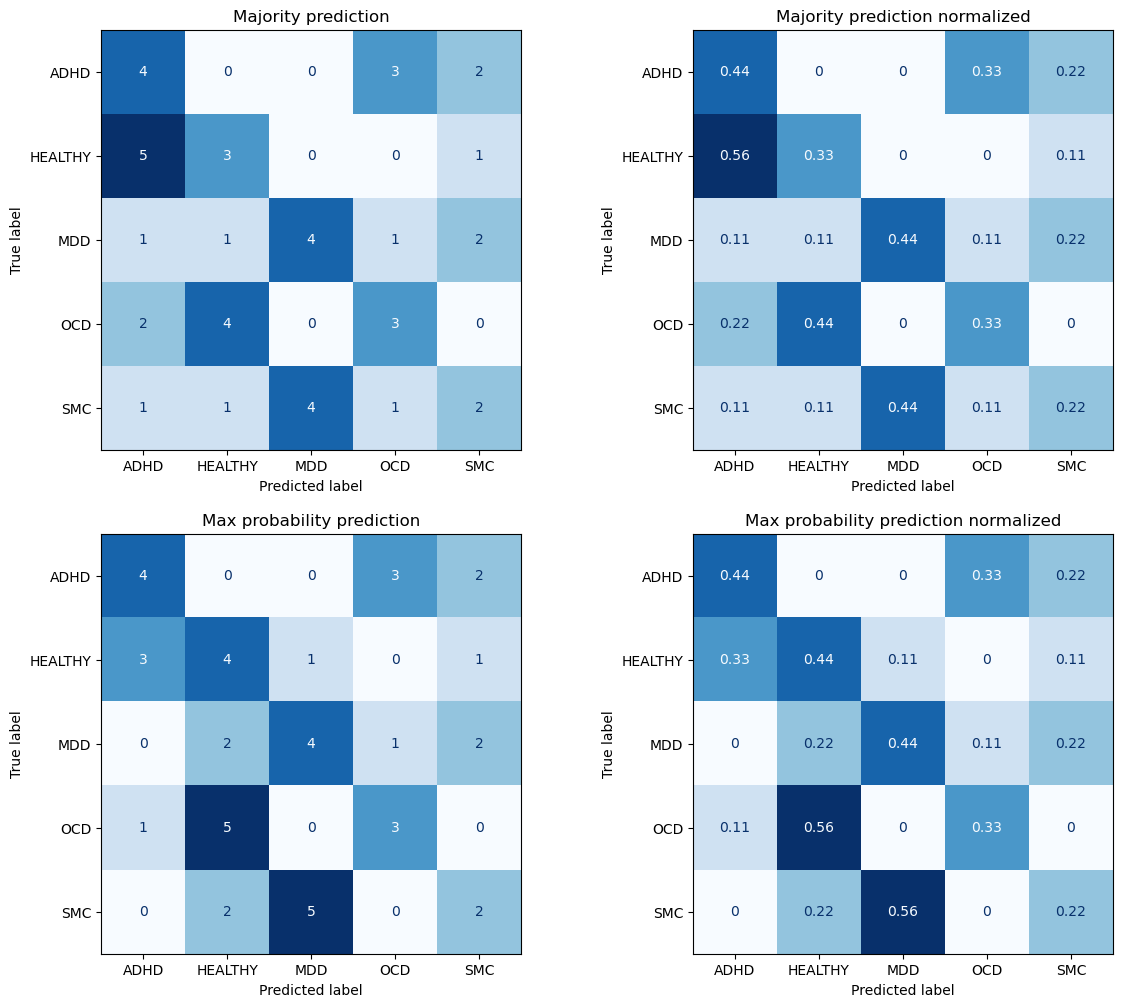

In [37]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

#### GraphLambda without edge attributes

In [38]:
best_model_path = r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\tuning_results\best_models_during_tuning_lightning_logs\eo_GL_wo_edge_best_model_logs\checkpoints\epoch=332-train_loss=0.43-train_f1=0.84-val_loss=2.79-val_f1=0.35.ckpt'
best_model_dir = '\\'.join(best_model_path.split('\\')[:-2]) + '\\'
print(best_model_dir)
hparams_path = best_model_dir + 'hparams.yaml'
# Load the hyperparameters from the YAML file
with open(hparams_path, 'r') as file:
    hyperparameters = yaml.safe_load(file)
print(hyperparameters)
learning_rate = hyperparameters['learning_rate']
optimizer_name = hyperparameters['optimizer_name']
dropout = hyperparameters['dropout']
edge_threshold = hyperparameters['edge_threshold']
fc_layers = hyperparameters['fc_layers']
best_model = graphLambda_wo_edge_attr.load_from_checkpoint(best_model_path, learning_rate=learning_rate, optimizer_name=optimizer_name, dropout=dropout, fc_layers=fc_layers)

print(best_model.hparams)

# final eval on test data for the best model during tuning
X_test_best_trial = [data.clone() for data in X_test]
for data in X_test_best_trial:
    data.edge_index = filter_adjacency(data.edge_index, data.edge_attr, edge_threshold)
test_loader = DataLoader(X_test_best_trial, batch_size=len(X_test), shuffle=False,
                            drop_last=True)

trainer = Trainer(accelerator='gpu', devices=1, enable_progress_bar=False, enable_model_summary=False, logger=False, enable_checkpointing=False)

# obtain predictions
y_proba = trainer.predict(best_model, test_loader)
y_pred = y_proba[0].argmax(dim=1)

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': groups_test, 'diagnosis': Y_test, 'prediction': y_pred.numpy(), 'proba': y_proba[0].numpy().tolist()})
df_predictions.head(3)

D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\tuning_results\best_models_during_tuning_lightning_logs\eo_GL_wo_edge_best_model_logs\
{'batch_size': 170, 'dropout': 0.491883119465696, 'edge_threshold': 0.8646462022716686, 'fc_layers': 5, 'learning_rate': 0.005193133600048374, 'optimizer_name': 'SGD'}



c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\utilities\migration\utils.py:56: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.2.1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


,ID,diagnosis,prediction,proba
0,sub-87964717,4,4,"[-7.99851655960083, -7.99851655960083, -3.0647..."
1,sub-87964717,4,4,"[-14.130546569824219, -13.186034202575684, -9...."
2,sub-87964717,4,4,"[-7.559318542480469, -4.960681438446045, -6.36..."


In [39]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = sum_probas['proba_prediction']

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_predictions.groupby('ID')['diagnosis'].first().values
df_patient_predictions.head(5)

,ID,prediction,proba_prediction,diagnosis
0,sub-87964717,4,4,4
1,sub-87966789,1,1,4
2,sub-87967509,3,3,4
3,sub-87967957,3,3,4
4,sub-87968541,4,4,4


In [40]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = le2.inverse_transform(np.unique(Y))

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.62      0.56      0.59         9
     HEALTHY       0.45      0.56      0.50         9
         MDD       0.43      0.33      0.38         9
         OCD       0.57      0.44      0.50         9
         SMC       0.42      0.56      0.48         9

    accuracy                           0.49        45
   macro avg       0.50      0.49      0.49        45
weighted avg       0.50      0.49      0.49        45

f1_score: 0.4878851540616246

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.80      0.44      0.57         9
     HEALTHY       0.60      0.67      0.63         9
         MDD       0.33      0.33      0.33         9
         OCD       0.50      0.44      0.47         9
         SMC       0.46      0.67      0.55         9

    accuracy                           0.51        45
   macro avg      

Text(0.5, 1.0, 'Max probability prediction normalized')

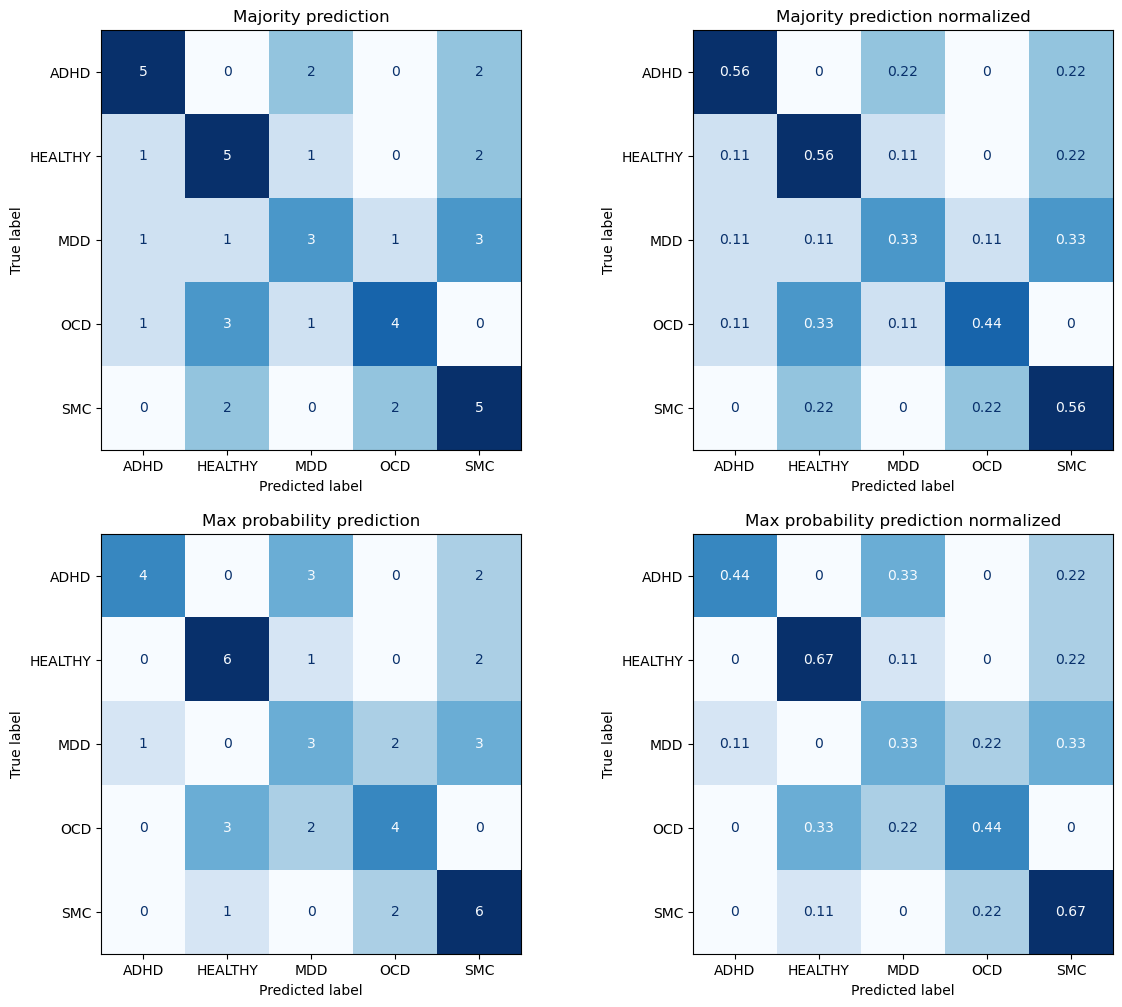

In [41]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

#### GraphLambda with edge attributes

In [42]:
best_model_path = r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\tuning_results\best_models_during_tuning_lightning_logs\eo_GL_with_edge_best_model_logs\checkpoints\epoch=83-train_loss=0.04-train_f1=0.99-val_loss=6.89-val_f1=0.34.ckpt'
best_model_dir = '\\'.join(best_model_path.split('\\')[:-2]) + '\\'
print(best_model_dir)
hparams_path = best_model_dir + 'hparams.yaml'
# Load the hyperparameters from the YAML file
with open(hparams_path, 'r') as file:
    hyperparameters = yaml.safe_load(file)
print(hyperparameters)
learning_rate = hyperparameters['learning_rate']
optimizer_name = hyperparameters['optimizer_name']
dropout = hyperparameters['dropout']
fc_layers = hyperparameters['fc_layers']
best_model = graphLambda_w_edge_attr.load_from_checkpoint(best_model_path, learning_rate=learning_rate, optimizer_name=optimizer_name, dropout=dropout, fc_layers=fc_layers)

print(best_model.hparams)

# final eval on test data for the best model during tuning
test_loader = DataLoader(X_test, batch_size=len(X_test), shuffle=False,
                            drop_last=True)

trainer = Trainer(accelerator='gpu', devices=1, enable_progress_bar=False, enable_model_summary=False, logger=False, enable_checkpointing=False)

# obtain predictions
y_proba = trainer.predict(best_model, test_loader)
y_pred = y_proba[0].argmax(dim=1)

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': groups_test, 'diagnosis': Y_test, 'prediction': y_pred.numpy(), 'proba': y_proba[0].numpy().tolist()})
df_predictions.head(3)

D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\tuning_results\best_models_during_tuning_lightning_logs\eo_GL_with_edge_best_model_logs\
{'batch_size': 510, 'dropout': 0.23748278915367405, 'fc_layers': 6, 'learning_rate': 0.00025437999522285833, 'optimizer_name': 'Adam'}


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\utilities\migration\utils.py:56: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.2.1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


,ID,diagnosis,prediction,proba
0,sub-87964717,4,0,"[-0.0004646890447475016, -8.774155616760254, -..."
1,sub-87964717,4,4,"[-13.98231315612793, -13.98231315612793, -13.9..."
2,sub-87964717,4,1,"[-11.23279857635498, -0.055935703217983246, -1..."


In [43]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = sum_probas['proba_prediction']

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_predictions.groupby('ID')['diagnosis'].first().values
df_patient_predictions.head(5)

,ID,prediction,proba_prediction,diagnosis
0,sub-87964717,2,2,4
1,sub-87966789,1,1,4
2,sub-87967509,2,2,4
3,sub-87967957,4,4,4
4,sub-87968541,2,2,4


In [44]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = le2.inverse_transform(np.unique(Y))

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.80      0.44      0.57         9
     HEALTHY       0.60      0.67      0.63         9
         MDD       0.17      0.22      0.19         9
         OCD       0.20      0.22      0.21         9
         SMC       0.12      0.11      0.12         9

    accuracy                           0.33        45
   macro avg       0.38      0.33      0.34        45
weighted avg       0.38      0.33      0.34        45

f1_score: 0.34433141677723716

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.80      0.44      0.57         9
     HEALTHY       0.50      0.56      0.53         9
         MDD       0.18      0.22      0.20         9
         OCD       0.20      0.22      0.21         9
         SMC       0.11      0.11      0.11         9

    accuracy                           0.31        45
   macro avg     

Text(0.5, 1.0, 'Max probability prediction normalized')

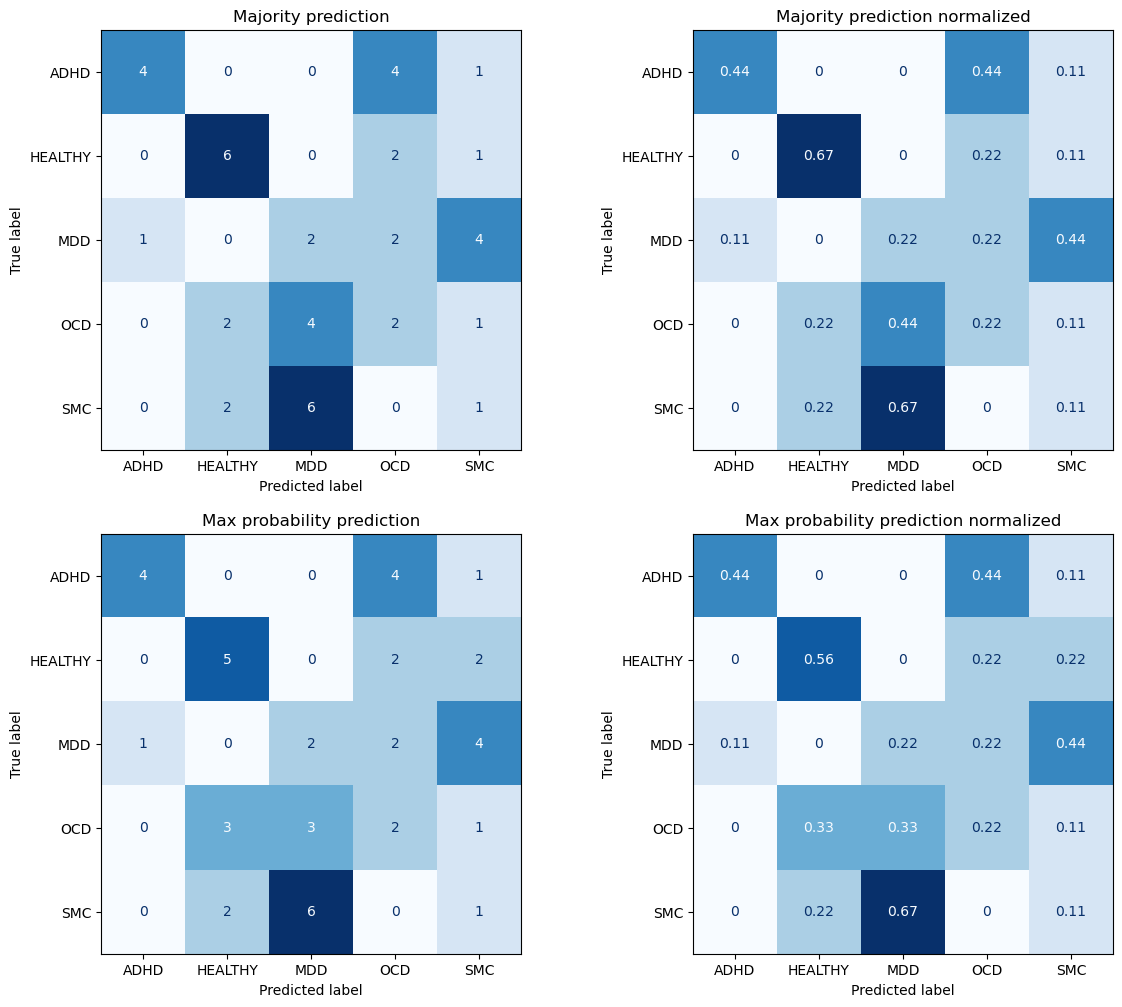

In [45]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

### Ratio

In [46]:
# split the data into train, validation and test sets, using the same split as one of the baseline models using nested cross-validation
baseline_train_ids = data_split_groups['ratio'][0]
baseline_val_ids = data_split_groups['ratio'][1]
baseline_test_ids = data_split_groups['ratio'][2]

# first splitting validation data using the first split from the baseline RF model
groups = [elem for elem in subjects_ratio_ids for i in range(12)] # times 12 for each epoch
groups_array = np.array(groups)
baseline_train_idxs = []
for train_id in baseline_train_ids:
    indices = np.where(groups_array == train_id)[0]  # Get the indices as an array
    baseline_train_idxs.extend(indices)  # Extend the list with the array of indices

baseline_val_idxs = []
for val_id in baseline_val_ids:
    indices = np.where(groups_array == val_id)[0]  # Get the indices as an array
    baseline_val_idxs.extend(indices)  # Extend the list with the array of indices

baseline_test_idxs = []
for test_id in baseline_test_ids:
    indices = np.where(groups_array == test_id)[0]  # Get the indices as an array
    baseline_test_idxs.extend(indices)  # Extend the list with the array of indices

print(len(baseline_train_idxs), len(baseline_val_idxs), len(baseline_test_idxs))

print(f'{len(ratio_graph_dataset) = }')
print(f'{len(baseline_train_idxs) = }, {len(baseline_val_idxs) = }, {len(baseline_test_idxs) = } total: {len(baseline_train_idxs)+len(baseline_val_idxs)+len(baseline_test_idxs)}')

X_train = [ratio_graph_dataset[i] for i in baseline_train_idxs] 
X_val = [ratio_graph_dataset[i] for i in baseline_val_idxs]
X_test = [ratio_graph_dataset[i] for i in baseline_test_idxs]
Y_train =[ratio_y_list[i] for i in baseline_train_idxs]
Y_val = [ratio_y_list[i] for i in baseline_val_idxs]
Y_test = [ratio_y_list[i] for i in baseline_test_idxs]
groups_train = [groups[i] for i in baseline_train_idxs]
groups_val = [groups[i] for i in baseline_val_idxs]
groups_test = [groups[i] for i in baseline_test_idxs]

1428 720 540
len(ratio_graph_dataset) = 2688
len(baseline_train_idxs) = 1428, len(baseline_val_idxs) = 720, len(baseline_test_idxs) = 540 total: 2688


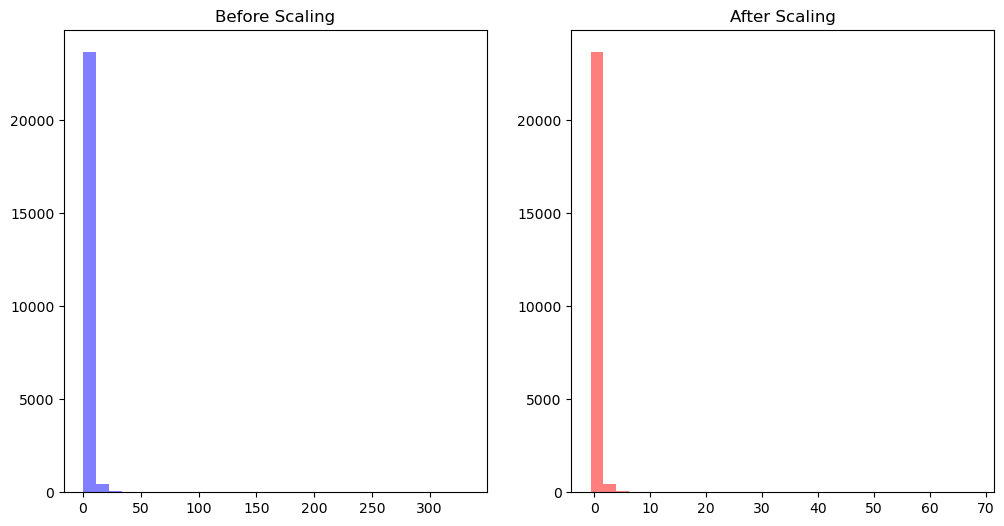

In [47]:
# standardize statistical node features
from sklearn.preprocessing import StandardScaler

# Concatenate all x values before scaling for the first feature, as a sanity check for standardization
x_before = np.concatenate([data.x.numpy()[:, 0] for data in X_train + X_val + X_test])

scaler = StandardScaler()
scaler.fit(np.vstack([data.x.numpy() for data in X_train + X_val]))


# Transform the x values of the data in X_train
for data in X_train:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Transform the x values of the data in X_val
for data in X_val:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Transform the x values of the data in X_test
for data in X_test:
    data.x = torch.from_numpy(scaler.transform(data.x.numpy()))

# Concatenate all x values after scaling for the first feature, as a sanity check for standardization
x_after = np.concatenate([data.x.numpy()[:, 0] for data in X_train + X_val + X_test])

# Plot the distribution of the first x feature before and after scaling as a sanity check
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(x_before, bins=30, color='b', alpha=0.5)
plt.title('Before Scaling')

plt.subplot(1, 2, 2)
plt.hist(x_after, bins=30, color='r', alpha=0.5)
plt.title('After Scaling')

plt.show()

#### standard GCN

In [48]:
best_model_path = r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\tuning_results\best_models_during_tuning_lightning_logs\ratio_stand_GCN_best_model_logs\checkpoints\epoch=55-train_loss=1.02-train_f1=0.60-val_loss=1.98-val_f1=0.25.ckpt'
best_model_dir = '\\'.join(best_model_path.split('\\')[:-2]) + '\\'
print(best_model_dir)
hparams_path = best_model_dir + 'hparams.yaml'
# Load the hyperparameters from the YAML file
with open(hparams_path, 'r') as file:
    hyperparameters = yaml.safe_load(file)
print(hyperparameters)
learning_rate = hyperparameters['learning_rate']
optimizer_name = hyperparameters['optimizer_name']
dropout = hyperparameters['dropout']
edge_threshold = hyperparameters['edge_threshold']
best_model = GCN.load_from_checkpoint(best_model_path, learning_rate=learning_rate, optimizer_name=optimizer_name, dropout=dropout)

print(best_model.hparams)

# final eval on test data for the best model during tuning
X_test_best_trial = [data.clone() for data in X_test]
for data in X_test_best_trial:
    data.edge_index = filter_adjacency(data.edge_index, data.edge_attr, edge_threshold)
test_loader = DataLoader(X_test_best_trial, batch_size=len(X_test), shuffle=False,
                            drop_last=True)

trainer = Trainer(accelerator='gpu', devices=1, enable_progress_bar=False, enable_model_summary=False, logger=False, enable_checkpointing=False)

# obtain predictions
y_proba = trainer.predict(best_model, test_loader)
y_pred = y_proba[0].argmax(dim=1)

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': groups_test, 'diagnosis': Y_test, 'prediction': y_pred.numpy(), 'proba': y_proba[0].numpy().tolist()})
df_predictions.head(3)

D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\tuning_results\best_models_during_tuning_lightning_logs\ratio_stand_GCN_best_model_logs\
{'batch_size': 510, 'dropout': 0.12245267416796006, 'edge_threshold': 0.7575571400876487, 'learning_rate': 0.0006242859250070882, 'optimizer_name': 'RMSprop'}



c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\utilities\migration\utils.py:56: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.2.1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


,ID,diagnosis,prediction,proba
0,sub-87965301,4,1,"[-2.3770508766174316, -1.196850061416626, -1.3..."
1,sub-87965301,4,3,"[-3.103524684906006, -1.0806896686553955, -2.9..."
2,sub-87965301,4,0,"[-1.1346337795257568, -2.495098352432251, -1.5..."


In [49]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = sum_probas['proba_prediction']

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_predictions.groupby('ID')['diagnosis'].first().values
df_patient_predictions.head(5)

,ID,prediction,proba_prediction,diagnosis
0,sub-87965301,0,0,4
1,sub-87967057,4,4,4
2,sub-87967729,4,4,4
3,sub-87968045,4,4,4
4,sub-87968677,0,0,4


In [50]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = le2.inverse_transform(np.unique(Y))

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.46      0.67      0.55         9
     HEALTHY       0.43      0.33      0.38         9
         MDD       0.00      0.00      0.00         9
         OCD       0.42      0.56      0.48         9
         SMC       0.42      0.56      0.48         9

    accuracy                           0.42        45
   macro avg       0.34      0.42      0.37        45
weighted avg       0.34      0.42      0.37        45

f1_score: 0.37456709956709955

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.50      0.33      0.40         9
     HEALTHY       0.50      0.44      0.47         9
         MDD       0.00      0.00      0.00         9
         OCD       0.40      0.67      0.50         9
         SMC       0.25      0.33      0.29         9

    accuracy                           0.36        45
   macro avg     

Text(0.5, 1.0, 'Max probability prediction normalized')

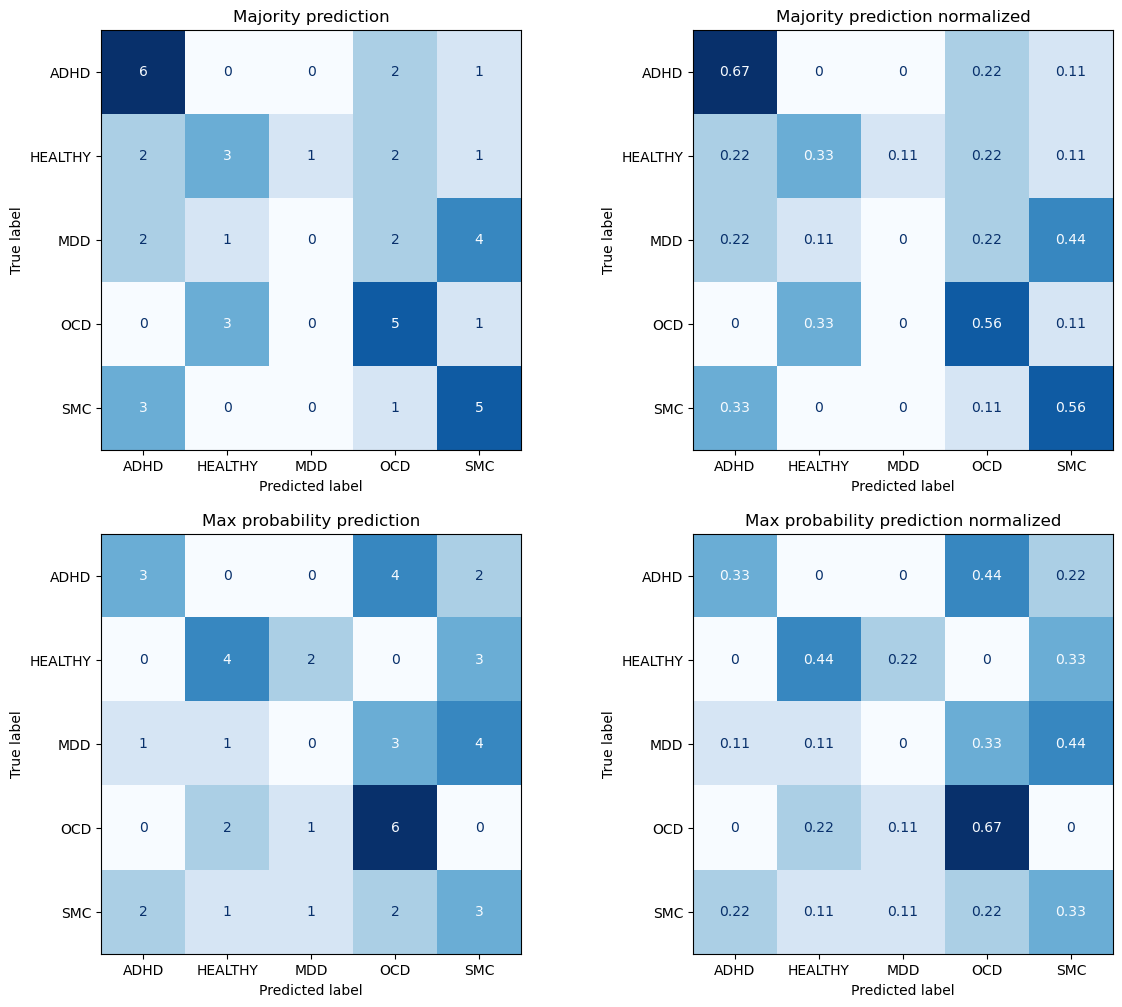

In [51]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

#### GraphLambda without edge attributes

In [52]:
best_model_path = r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\tuning_results\best_models_during_tuning_lightning_logs\ratio_GL_wo_edge_best_model_logs\checkpoints\epoch=2503-train_loss=0.00-train_f1=1.00-val_loss=5.14-val_f1=0.22.ckpt'
best_model_dir = '\\'.join(best_model_path.split('\\')[:-2]) + '\\'
print(best_model_dir)
hparams_path = best_model_dir + 'hparams.yaml'
# Load the hyperparameters from the YAML file
with open(hparams_path, 'r') as file:
    hyperparameters = yaml.safe_load(file)
print(hyperparameters)
learning_rate = hyperparameters['learning_rate']
optimizer_name = hyperparameters['optimizer_name']
dropout = hyperparameters['dropout']
edge_threshold = hyperparameters['edge_threshold']
fc_layers = hyperparameters['fc_layers']
best_model = graphLambda_wo_edge_attr.load_from_checkpoint(best_model_path, learning_rate=learning_rate, optimizer_name=optimizer_name, dropout=dropout, fc_layers=fc_layers)

print(best_model.hparams)

# final eval on test data for the best model during tuning
X_test_best_trial = [data.clone() for data in X_test]
for data in X_test_best_trial:
    data.edge_index = filter_adjacency(data.edge_index, data.edge_attr, edge_threshold)
test_loader = DataLoader(X_test_best_trial, batch_size=len(X_test), shuffle=False,
                            drop_last=True)

trainer = Trainer(accelerator='gpu', devices=1, enable_progress_bar=False, enable_model_summary=False, logger=False, enable_checkpointing=False)

# obtain predictions
y_proba = trainer.predict(best_model, test_loader)
y_pred = y_proba[0].argmax(dim=1)

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': groups_test, 'diagnosis': Y_test, 'prediction': y_pred.numpy(), 'proba': y_proba[0].numpy().tolist()})
df_predictions.head(3)

D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\tuning_results\best_models_during_tuning_lightning_logs\ratio_GL_wo_edge_best_model_logs\
{'batch_size': 850, 'dropout': 0.05066888473079148, 'edge_threshold': 0.6798223930859607, 'fc_layers': 3, 'learning_rate': 0.010054058167807403, 'optimizer_name': 'SGD'}


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\utilities\migration\utils.py:56: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.2.1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


,ID,diagnosis,prediction,proba
0,sub-87965301,4,3,"[-4.330561637878418, -0.8072435259819031, -3.5..."
1,sub-87965301,4,1,"[-1.8111358880996704, -0.2457342892885208, -8...."
2,sub-87965301,4,0,"[-0.0001494772732257843, -12.75162410736084, -..."


In [53]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = sum_probas['proba_prediction']

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_predictions.groupby('ID')['diagnosis'].first().values
df_patient_predictions.head(5)

,ID,prediction,proba_prediction,diagnosis
0,sub-87965301,3,3,4
1,sub-87967057,4,4,4
2,sub-87967729,4,4,4
3,sub-87968045,4,4,4
4,sub-87968677,0,0,4


In [54]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = le2.inverse_transform(np.unique(Y))

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.44      0.89      0.59         9
     HEALTHY       0.50      0.22      0.31         9
         MDD       0.17      0.11      0.13         9
         OCD       0.50      0.22      0.31         9
         SMC       0.31      0.44      0.36         9

    accuracy                           0.38        45
   macro avg       0.38      0.38      0.34        45
weighted avg       0.38      0.38      0.34        45

f1_score: 0.340989380989381

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.50      0.78      0.61         9
     HEALTHY       0.67      0.44      0.53         9
         MDD       0.00      0.00      0.00         9
         OCD       0.43      0.33      0.38         9
         SMC       0.21      0.33      0.26         9

    accuracy                           0.38        45
   macro avg       

Text(0.5, 1.0, 'Max probability prediction normalized')

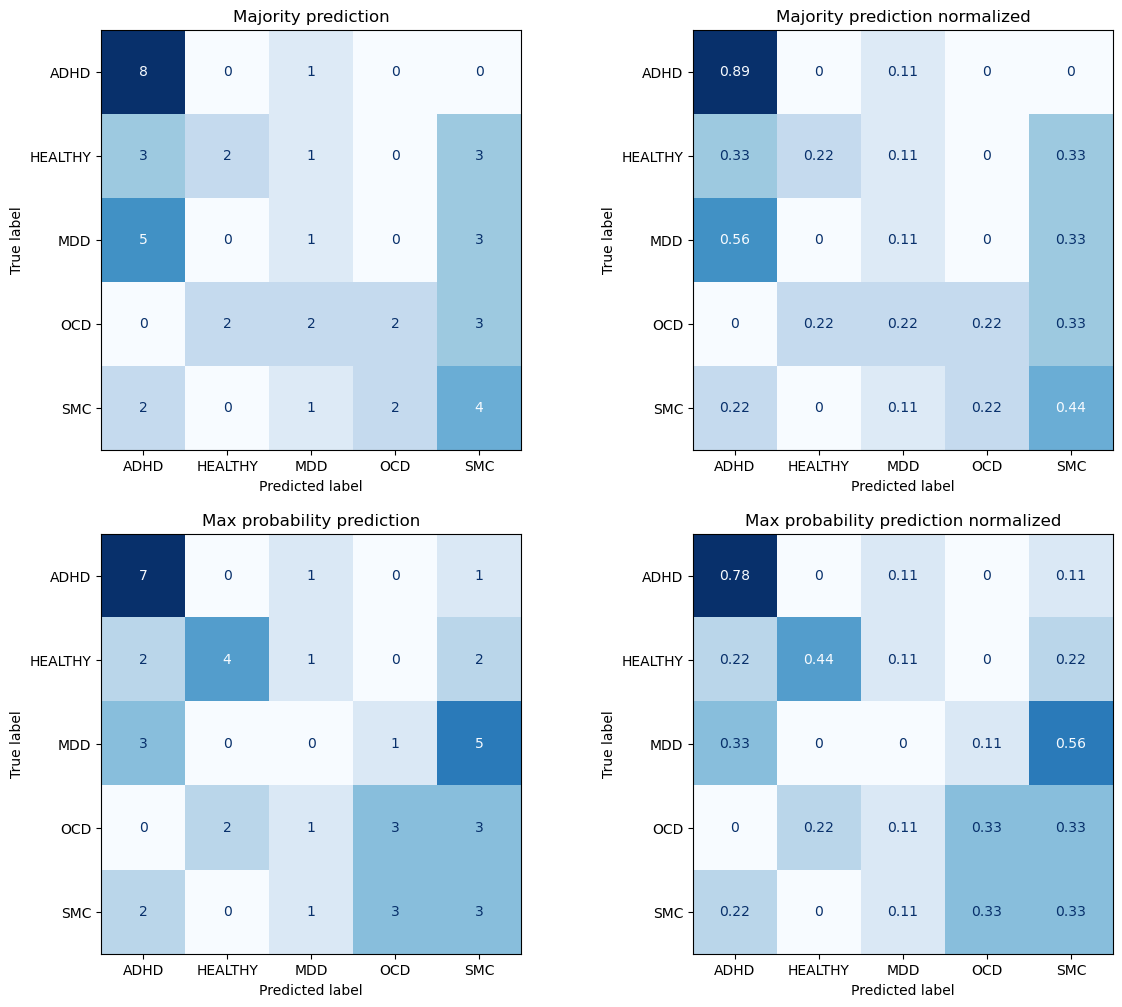

In [55]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

#### GraphLambda with edge attributes

In [56]:
best_model_path = r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\tuning_results\best_models_during_tuning_lightning_logs\ratio_GL_with_edge_best_model_logs\checkpoints\epoch=423-train_loss=0.05-train_f1=0.99-val_loss=8.08-val_f1=0.23.ckpt'
best_model_dir = '\\'.join(best_model_path.split('\\')[:-2]) + '\\'
print(best_model_dir)
hparams_path = best_model_dir + 'hparams.yaml'
# Load the hyperparameters from the YAML file
with open(hparams_path, 'r') as file:
    hyperparameters = yaml.safe_load(file)
print(hyperparameters)
learning_rate = hyperparameters['learning_rate']
optimizer_name = hyperparameters['optimizer_name']
dropout = hyperparameters['dropout']
fc_layers = hyperparameters['fc_layers']
best_model = graphLambda_w_edge_attr.load_from_checkpoint(best_model_path, learning_rate=learning_rate, optimizer_name=optimizer_name, dropout=dropout, fc_layers=fc_layers)

print(best_model.hparams)

# final eval on test data for the best model during tuning
test_loader = DataLoader(X_test, batch_size=len(X_test), shuffle=False,
                            drop_last=True)
trainer = Trainer(accelerator='gpu', devices=1, enable_progress_bar=False, enable_model_summary=False, logger=False, enable_checkpointing=False)

# obtain predictions
y_proba = trainer.predict(best_model, test_loader)
y_pred = y_proba[0].argmax(dim=1)

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': groups_test, 'diagnosis': Y_test, 'prediction': y_pred.numpy(), 'proba': y_proba[0].numpy().tolist()})
df_predictions.head(3)

D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\tuning_results\best_models_during_tuning_lightning_logs\ratio_GL_with_edge_best_model_logs\
{'batch_size': 850, 'dropout': 0.2532377504886759, 'fc_layers': 7, 'learning_rate': 2.8351247448816293e-05, 'optimizer_name': 'RMSprop'}


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\utilities\migration\utils.py:56: The loaded checkpoint was produced with Lightning v2.4.0, which is newer than your current Lightning version: v2.2.1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


,ID,diagnosis,prediction,proba
0,sub-87965301,4,1,"[-7.871859073638916, -0.12356747686862946, -2...."
1,sub-87965301,4,1,"[-15.418563842773438, -4.029192859889008e-05, ..."
2,sub-87965301,4,0,"[-6.12716976320371e-05, -17.504812240600586, -..."


In [57]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = sum_probas['proba_prediction']

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_predictions.groupby('ID')['diagnosis'].first().values
df_patient_predictions.head(5)

,ID,prediction,proba_prediction,diagnosis
0,sub-87965301,0,3,4
1,sub-87967057,4,4,4
2,sub-87967729,4,2,4
3,sub-87968045,4,4,4
4,sub-87968677,0,0,4


In [58]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = le2.inverse_transform(np.unique(Y))

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.58      0.78      0.67         9
     HEALTHY       0.40      0.22      0.29         9
         MDD       0.19      0.33      0.24         9
         OCD       0.33      0.22      0.27         9
         SMC       0.50      0.33      0.40         9

    accuracy                           0.38        45
   macro avg       0.40      0.38      0.37        45
weighted avg       0.40      0.38      0.37        45

f1_score: 0.37180952380952387

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.54      0.78      0.64         9
     HEALTHY       0.50      0.22      0.31         9
         MDD       0.20      0.44      0.28         9
         OCD       0.40      0.22      0.29         9
         SMC       0.67      0.22      0.33         9

    accuracy                           0.38        45
   macro avg     

Text(0.5, 1.0, 'Max probability prediction normalized')

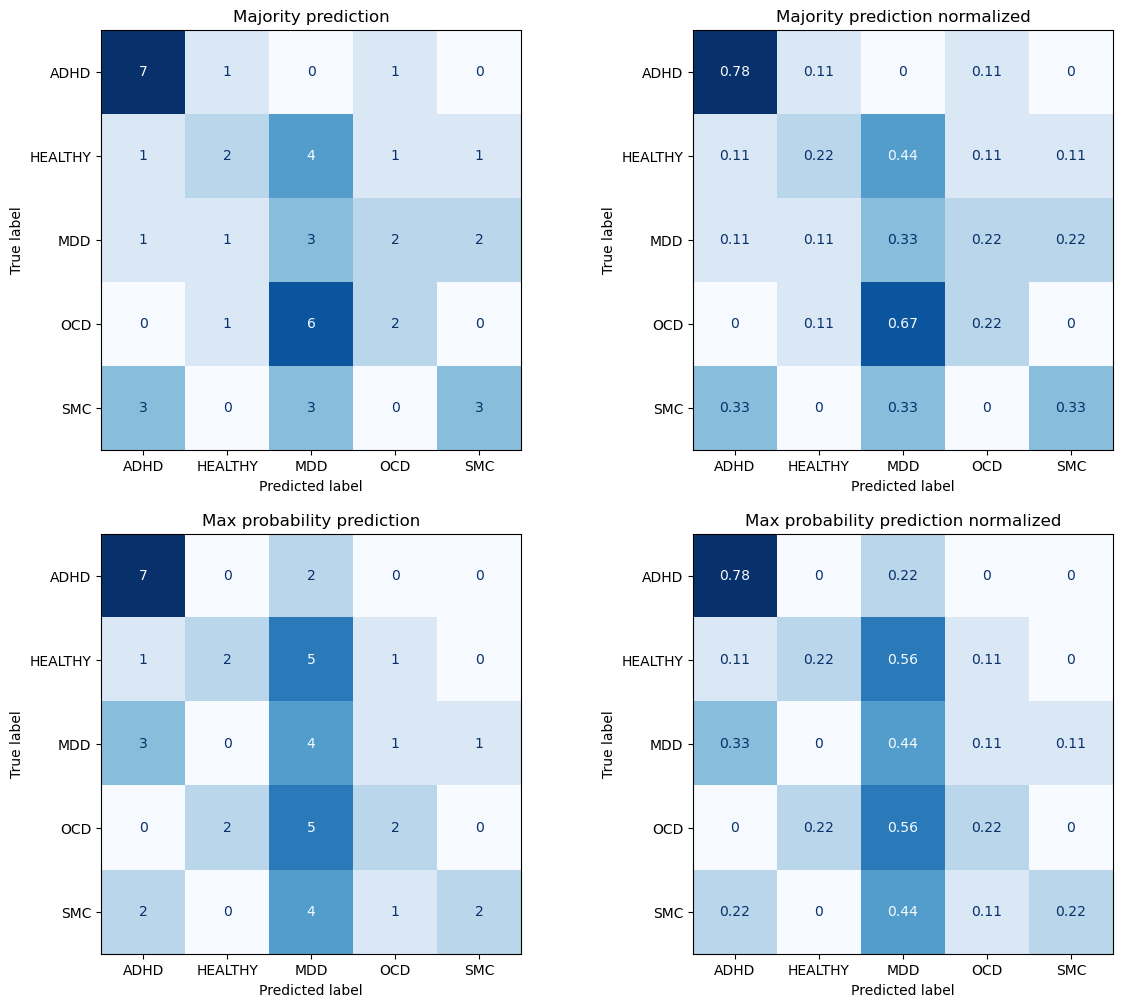

In [59]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')